In [42]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

from StatTools.experimental.augmentation.perturbations import (
    add_noise,
    add_poisson_gaps,
)
from StatTools.experimental.analysis.tools import get_extra_h_dfa
from StatTools.experimental.synthesis.tools import (
    adjust_hurst_to_range,
    reverse_hurst_adjustment,
)
from kalman_experiments import (
    get_signal,
    get_r_list,
    apply_kalman_filter,
    apply_kalman_filter_cached
)

### Experimental variables

| Variable              | Value                                     |
|-------------------------|----------------------------------------------|
| $ H $                 | $1/2$ to $3.5$, step is $1/4$              |
| Length of the forming filter, s   | open length |
| Order of the Kalman filter, r   | 2, 4, 8                                          |
| SNR     | $0.5, 1, 2$  |

In [43]:
H_LIST = np.arange(0.5, 3.75, 0.25)
TRJ_LEN_POW = 14
TRJ_LEN = 2**TRJ_LEN_POW

In [44]:
markers = [
    "o",  # circle
    "v",  # triangle_down
    "^",  # triangle_up
    "<",  # triangle_left
    ">",  # triangle_right
    "s",  # square
    "p",  # pentagon
    "*",  # star
    "h",  # hexagon
]

axis_fontsize = 14
label_fontsize = 14
legend_fontsize = 14
title_fontsize = 16

In [45]:
output_path = Path("./out")
kalman_cache_folder = Path("/home/jovyan/git/FluctuationAnalysisTools/filter_matrices")

## Signal synthesis

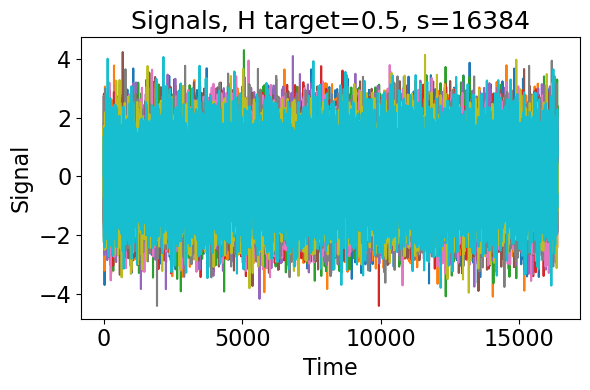

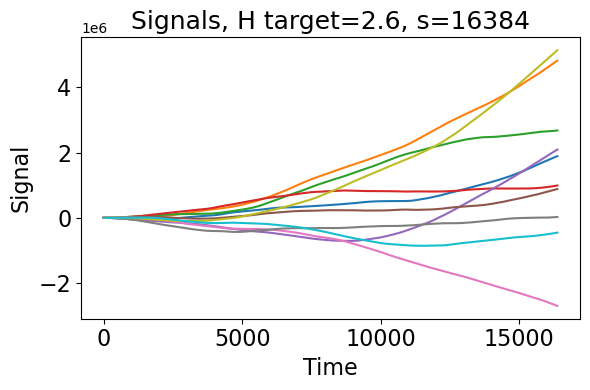

In [11]:
h = 0.5
s = TRJ_LEN
plt.figure(figsize=(6, 4))
for _ in range(10):
    signal = get_signal(h, TRJ_LEN, s)
    plt.plot(signal)

plt.title(f"Signals, H target={h}, s={s}", fontdict={"fontsize": 18})
plt.xlabel("Time", fontsize=16)
plt.ylabel("Signal", fontsize=16)
plt.tick_params(labelsize=16)
plt.tight_layout()
# plt.savefig(f"./out/signals_{h}.svg")
plt.show()

h = 2.6
s = TRJ_LEN
plt.figure(figsize=(6, 4))
for _ in range(10):
    signal = get_signal(h, TRJ_LEN, s)
    plt.plot(signal)

plt.title(f"Signals, H target={h}, s={s}", fontdict={"fontsize": 18})
plt.xlabel("Time", fontsize=16)
plt.ylabel("Signal", fontsize=16)
plt.tick_params(labelsize=16)
plt.tight_layout()
# plt.savefig(f"./out/signals_{h}.svg")
plt.show()

## Estimation of the synthesis error

In [11]:
test_df = pd.DataFrame(
    columns=[
        "H_target",
        "H_signal",
        "signal_len",
        "s",
    ]
)

In [15]:
s = TRJ_LEN
for h in H_LIST:
    for _ in tqdm(range(15)):
        signal = get_signal(h, TRJ_LEN, s)
        h_signal = get_extra_h_dfa(signal)
        test_df.loc[len(test_df)] = [
            h,
            h_signal,
            len(signal),
            s,
        ]

  0%|          | 0/15 [00:00<?, ?it/s]/opt/conda/lib/python3.11/site-packages/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(
  7%|▋         | 1/15 [00:02<00:37,  2.66s/it]/opt/conda/lib/python3.11/site-packages/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(
 13%|█▎        | 2/15 [00:05<00:34,  2.68s/it]/opt/conda/lib/python3.11/site-packages/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(
 20%|██        | 3/15 [00:08<00:32,  2.69s/it]/opt/conda/lib/python3.11/site-packages/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(
 27%|██▋       | 4/15 [00:10<00:29,  2.70s/it]/opt/conda/lib/python3.11/site-packages/StatTools/gene

In [16]:
test_df["H_gen_diff"] = abs(test_df["H_target"] - test_df["H_signal"])

In [17]:
test_df

H_target  H_signal  signal_len        s  H_gen_diff
0         0.5  0.471656     16384.0  16384.0    0.028344
1         0.5  0.504204     16384.0  16384.0    0.004204
2         0.5  0.509779     16384.0  16384.0    0.009779
3         0.5  0.513498     16384.0  16384.0    0.013498
4         0.5  0.526140     16384.0  16384.0    0.026140
..        ...       ...         ...      ...         ...
261       3.5  3.496047     16384.0  16384.0    0.003953
262       3.5  3.489703     16384.0  16384.0    0.010297
263       3.5  3.488679     16384.0  16384.0    0.011321
264       3.5  3.463679     16384.0  16384.0    0.036321
265       3.5  3.507813     16384.0  16384.0    0.007813

[266 rows x 5 columns]

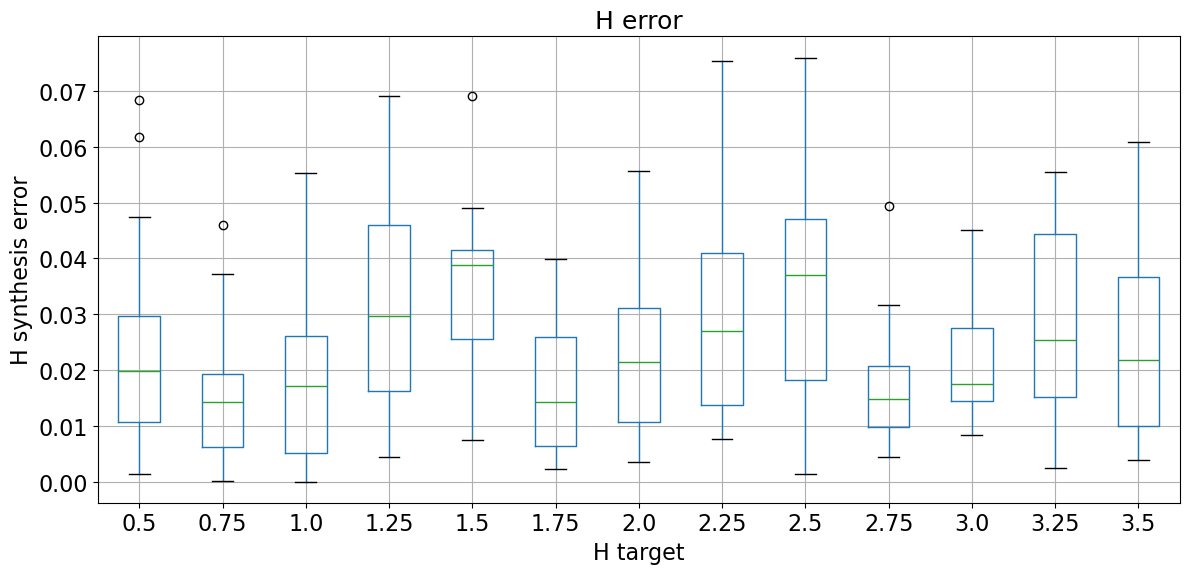

In [19]:
ax = test_df.boxplot(column="H_gen_diff", by="H_target", figsize=(12, 6))
plt.title("H error", fontdict={"fontsize": 18})
plt.suptitle("")
plt.xlabel("H target", fontsize=16)
plt.ylabel("H synthesis error", fontsize=16)
plt.tick_params(labelsize=16)
plt.tight_layout()
plt.savefig("./out/H_synthesis_error.svg")
plt.show()

## Experiment-Synthetics

### Gaps

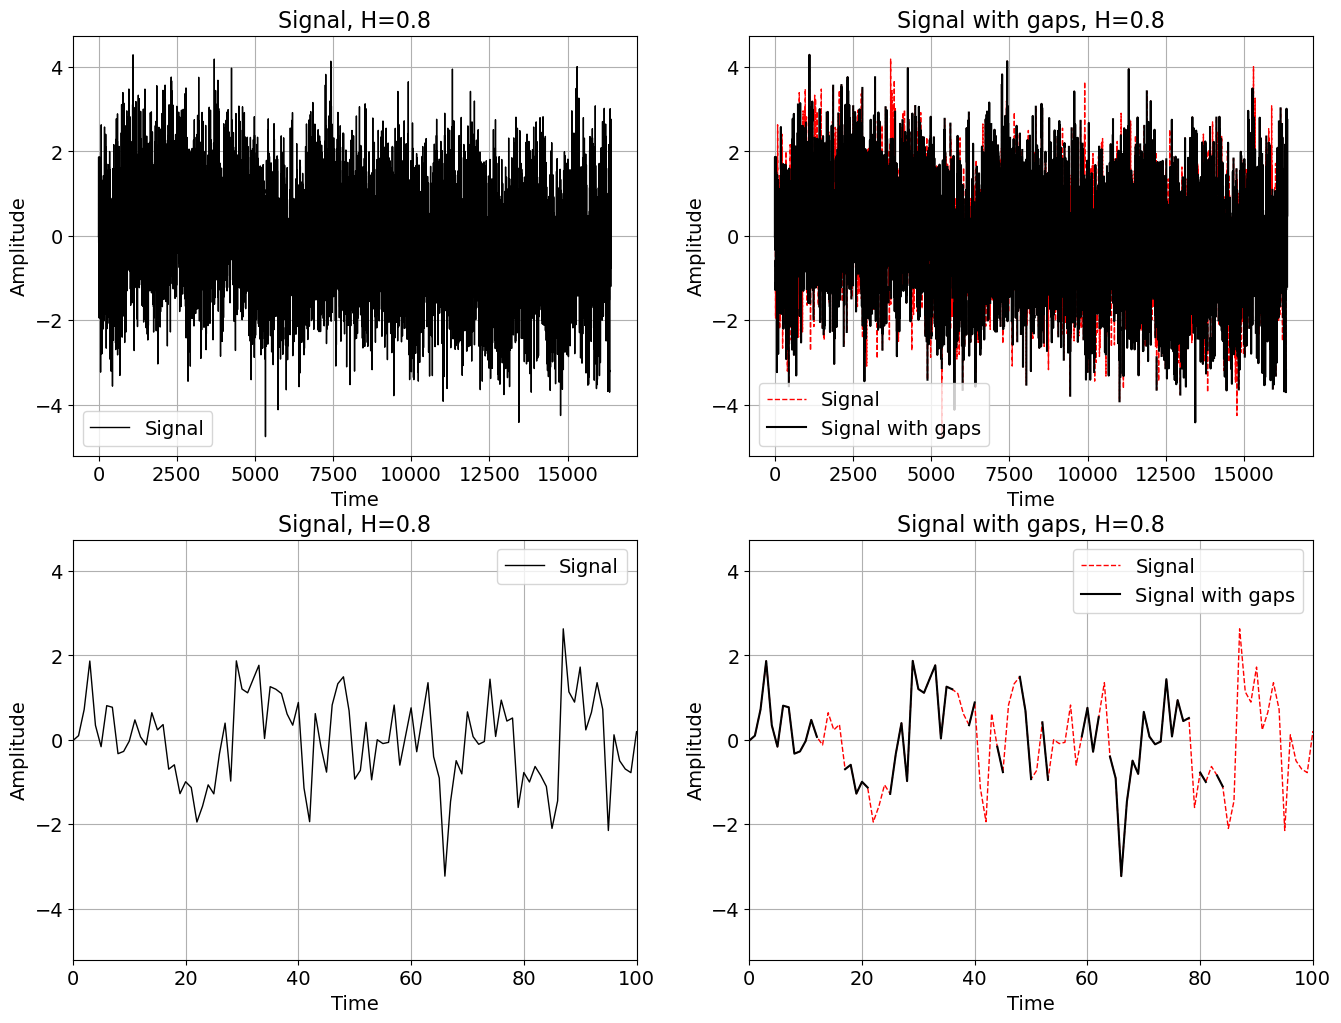

In [20]:
s = TRJ_LEN
h = 0.8
generated_signal = get_signal(h, TRJ_LEN, s)
gap_rate = 0.2
length_rate = 2.0
gaps_signal, gaps = add_poisson_gaps(generated_signal, gap_rate, length_rate)

plt.figure(figsize=(16, 12))
plt.subplot(2, 2, 1)
plt.plot(generated_signal, label="Signal", color="black", linewidth=1)
plt.xlabel("Time", fontsize=axis_fontsize)
plt.ylabel("Amplitude", fontsize=axis_fontsize)
plt.legend(fontsize=legend_fontsize)
plt.tick_params(labelsize=label_fontsize)
plt.grid(True)
plt.title(f"Signal, H={h}", fontdict={"fontsize": title_fontsize})

plt.subplot(2, 2, 2)
plt.plot(
    generated_signal,
    label="Signal",
    color="red",
    linestyle="--",
    linewidth=1,
)
plt.plot(gaps_signal, label="Signal with gaps", color="black")
plt.xlabel("Time", fontsize=axis_fontsize)
plt.ylabel("Amplitude", fontsize=axis_fontsize)
plt.legend(fontsize=legend_fontsize)
plt.tick_params(labelsize=label_fontsize)
plt.grid(True)
plt.title(f"Signal with gaps, H={h}", fontdict={"fontsize": title_fontsize})

plt.subplot(2, 2, 3)
plt.plot(generated_signal, label="Signal", color="black", linewidth=1)
plt.xlabel("Time", fontsize=axis_fontsize)
plt.ylabel("Amplitude", fontsize=axis_fontsize)
plt.legend(fontsize=legend_fontsize)
plt.tick_params(labelsize=label_fontsize)
plt.xlim(0, 100)
plt.grid(True)
plt.title(f"Signal, H={h}", fontdict={"fontsize": title_fontsize})

plt.subplot(2, 2, 4)
plt.plot(
    generated_signal,
    label="Signal",
    color="red",
    linestyle="--",
    linewidth=1,
)
plt.plot(gaps_signal, label="Signal with gaps", color="black")
plt.xlabel("Time", fontsize=axis_fontsize)
plt.ylabel("Amplitude", fontsize=axis_fontsize)
plt.legend(fontsize=legend_fontsize)
plt.tick_params(labelsize=label_fontsize)
plt.grid(True)
plt.xlim(0, 100)
plt.title(f"Signal with gaps, H={h}", fontdict={"fontsize": title_fontsize})
plt.show()


In [21]:
metrics_df = pd.DataFrame(
    columns=[
        "H_target",
        "H_signal",
        "H_restored",
        "signal_len",
        "s",
        "r",
        "gap_rate",
        "length_rate",
        "SE",
    ]
)

ValueError: cannot set a row with mismatched columns

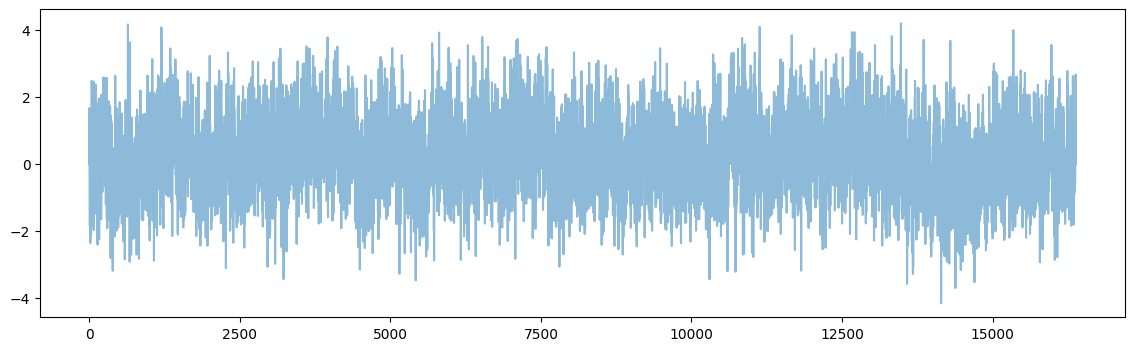

In [9]:
# one process version with plot
s = TRJ_LEN
axis_fontsize = 14
label_fontsize = 14
legend_fontsize = 14
title_fontsize = 16
n = 1
gap_rate = 0.2
length_rate = 2.0
for h in H_LIST[0:9]:
    se_dict = {}
    for r in get_r_list():
        se_dict[r] = []

    for i in range(n):
        signal = get_signal(h, TRJ_LEN, s, normalize=False)
        if i == 0:
            plt.figure(figsize=(14, 4))
        new_signal = signal
        if get_extra_h_dfa(signal) > 1.5:
            new_signal = np.diff(signal)
        gaps_signal, _ = add_poisson_gaps(generated_signal, gap_rate, length_rate)

        r_list = get_r_list()
        h_s = get_extra_h_dfa(signal)
        for r in r_list:
            estimated_signal = apply_kalman_filter(gaps_signal, h, r)
            if get_extra_h_dfa(signal) > 1.5:
                estimated_signal = np.cumsum(estimated_signal)

            se = np.nanstd(signal[0 : len(estimated_signal)] - estimated_signal)
            se_dict[r].append(se)

            h_est = get_extra_h_dfa(estimated_signal)
            if i == 0:
                plt.plot(
                    estimated_signal,
                    label=f"Filter output ({r}), SE={se:.3f}, Hs={h_s:.2f}, He={h_est:.2f}",
                    alpha=0.5,
                )

            metrics_df.loc[len(metrics_df)] = [
                h,
                h_s,
                h_est,
                len(signal),
                s,
                r,
                gap_rate,
                length_rate,
                se,
            ]

        if i == 0:
            plt.plot(
                signal,
                label="Signal",
                color="red",
                alpha=0.5,
                linewidth=1,
            )
            plt.xlabel("Time", fontsize=axis_fontsize)
            plt.ylabel("Amplitude", fontsize=axis_fontsize)
            # plt.xlim(2000, 2100)
            plt.legend(fontsize=legend_fontsize)
            plt.tick_params(labelsize=label_fontsize)
            plt.title(
                f"Result of the filtering, $\\hat{{H}}=${h}, gaps length rate={length_rate}",
                fontdict={"fontsize": title_fontsize},
            )
            plt.grid(True)
            plt.show()

    for k, v in se_dict.items():
        print(f"H={h}, SE (order {k}): {np.mean(v):.3f}+-{np.std(v):.3f}")

In [26]:
metrics_df.to_csv("./out/kalman-kasdin-gaps.csv", index=False)

#### Analysis

In [27]:
metrics_df = pd.read_csv("./out/kalman-kasdin-gaps.csv")
metrics_df.head()

H_target  H_signal  H_restored  signal_len        s    r  gap_rate  \
0      0.50  0.510208    0.746558     16384.0  16384.0  2.0       0.2   
1      0.50  0.510208    0.746558     16384.0  16384.0  4.0       0.2   
2      0.50  0.510208    0.746558     16384.0  16384.0  8.0       0.2   
3      0.75  0.734819    0.776782     16384.0  16384.0  2.0       0.2   
4      0.75  0.734819    0.790996     16384.0  16384.0  4.0       0.2   

   length_rate        SE  
0          2.0  1.395685  
1          2.0  1.395685  
2          2.0  1.395685  
3          2.0  1.456856  
4          2.0  1.468759

In [28]:
metrics_df["H_restore_diff"] = abs(metrics_df["H_signal"] - metrics_df["H_restored"])
metrics_df["H_gen_diff"] = abs(metrics_df["H_target"] - metrics_df["H_signal"])

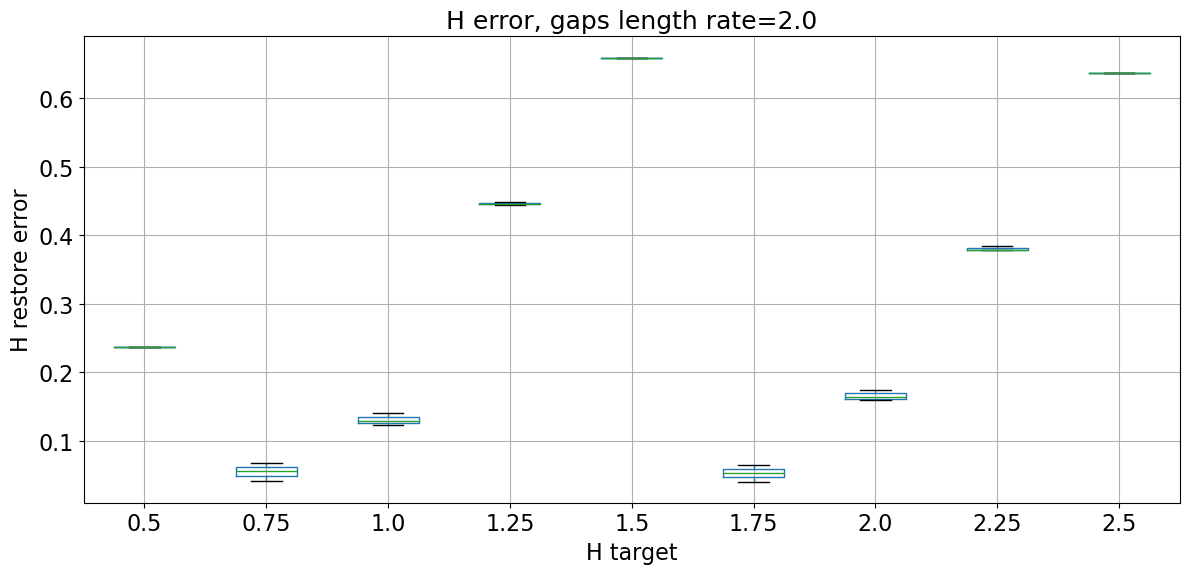

In [ ]:
for length_rate in metrics_df["length_rate"].unique():
    part_metrics_df = metrics_df[metrics_df["length_rate"] == length_rate]
    ax = part_metrics_df.boxplot(
        column="H_restore_diff", by="H_target", figsize=(12, 6)
    )
    plt.title(f"H error, gaps length rate={length_rate}", fontdict={"fontsize": 18})
    plt.suptitle("")
    plt.xlabel("H target", fontsize=16)
    plt.ylabel("H restore error", fontsize=16)
    plt.tick_params(labelsize=16)
    plt.tight_layout()
    plt.show()

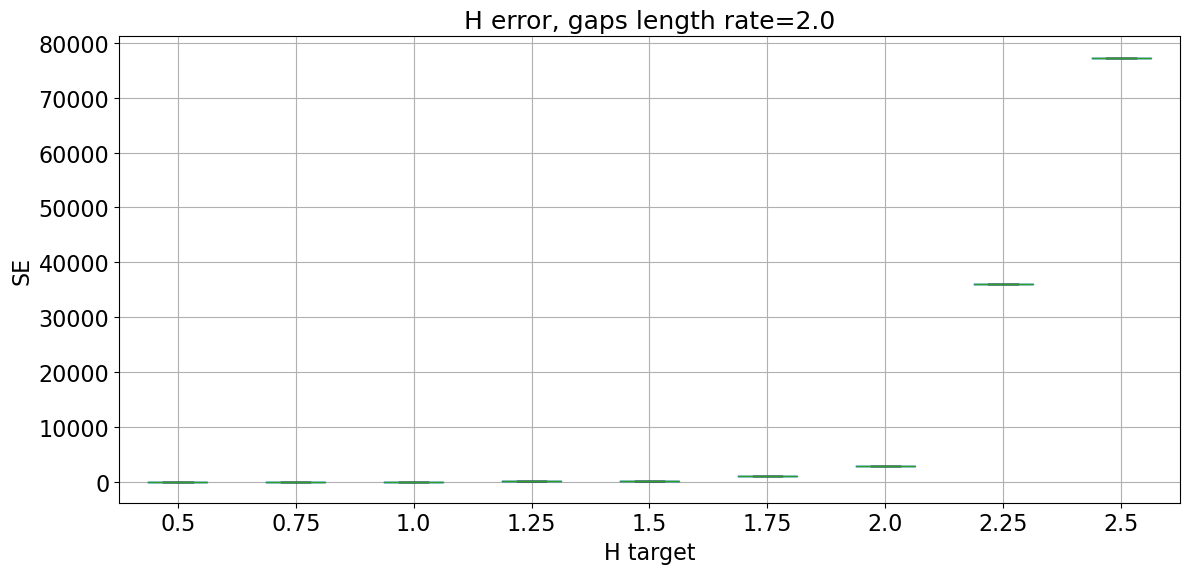

In [33]:
for length_rate in metrics_df["length_rate"].unique():
    part_metrics_df = metrics_df[metrics_df["length_rate"] == length_rate]
    ax = part_metrics_df.boxplot(column="SE", by="H_target", figsize=(12, 6))
    plt.title(f"H error, gaps length rate={length_rate}", fontdict={"fontsize": 18})
    plt.suptitle("")
    plt.xlabel("H target", fontsize=16)
    plt.ylabel("SE", fontsize=16)
    plt.tick_params(labelsize=16)
    plt.tight_layout()
    plt.show()

### Noise

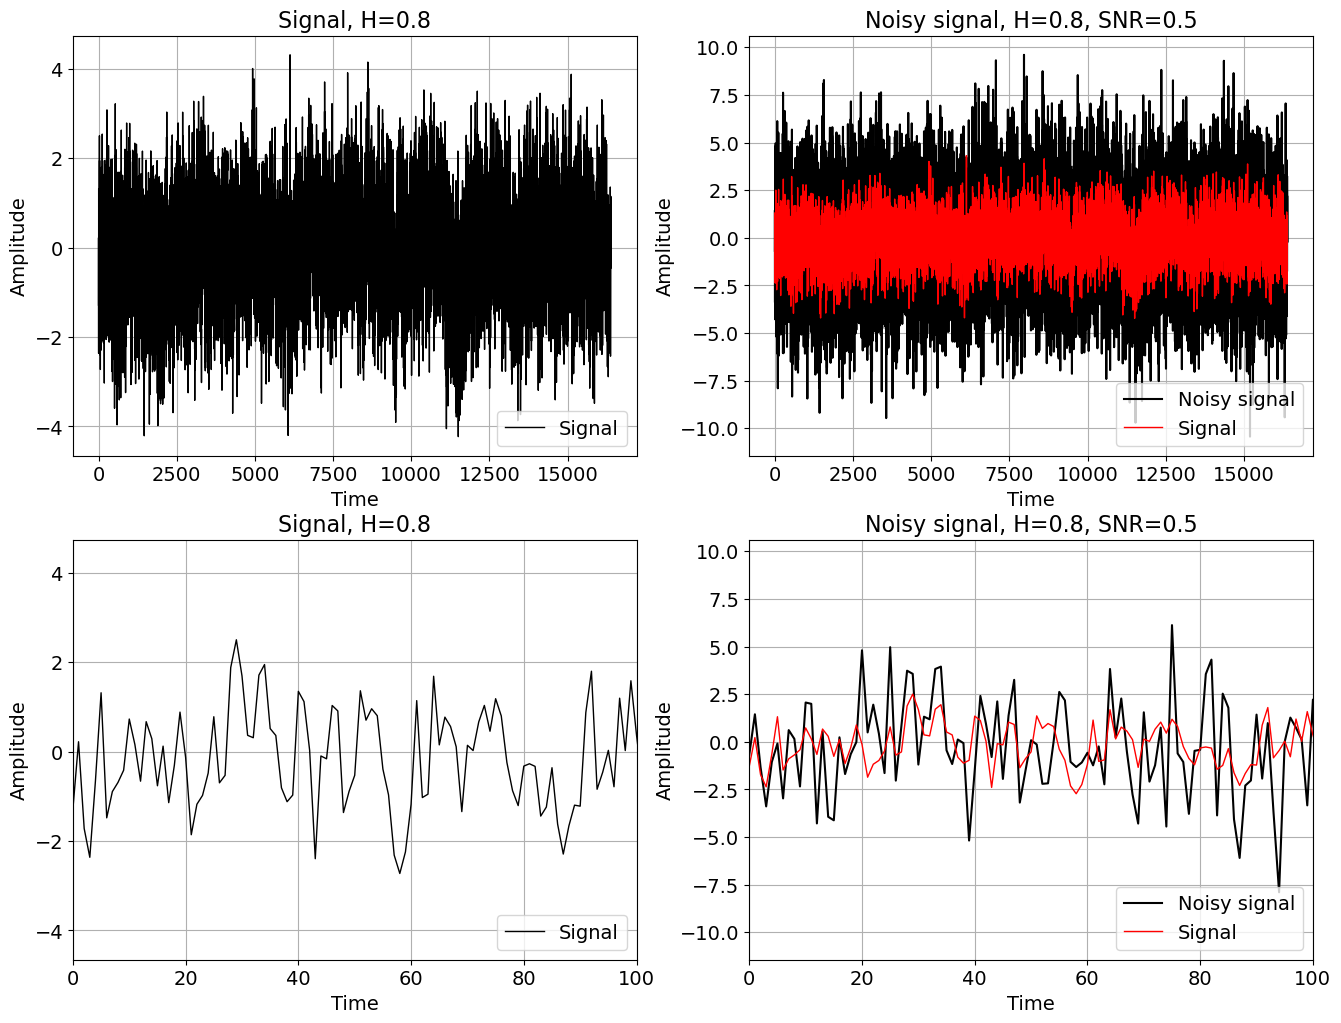

In [12]:
s = TRJ_LEN
h = 0.8
generated_signal = get_signal(h, TRJ_LEN, s)
snr = 0.5
noisy_signal, _ = add_noise(generated_signal, snr)

plt.figure(figsize=(16, 12))
plt.subplot(2, 2, 1)
plt.plot(generated_signal, label="Signal", color="black", linewidth=1)
plt.xlabel("Time", fontsize=axis_fontsize)
plt.ylabel("Amplitude", fontsize=axis_fontsize)
plt.legend(fontsize=legend_fontsize, loc="lower right")
plt.tick_params(labelsize=label_fontsize)
plt.grid(True)
plt.title(f"Signal, H={h}", fontdict={"fontsize": title_fontsize})

plt.subplot(2, 2, 2)
plt.plot(noisy_signal, label="Noisy signal", color="black")
plt.plot(
    generated_signal,
    label="Signal",
    color="red",
    linewidth=1,
)
plt.xlabel("Time", fontsize=axis_fontsize)
plt.ylabel("Amplitude", fontsize=axis_fontsize)
plt.legend(fontsize=legend_fontsize, loc="lower right")
plt.tick_params(labelsize=label_fontsize)
plt.grid(True)
plt.title(f"Noisy signal, H={h}, SNR={snr}", fontdict={"fontsize": title_fontsize})

plt.subplot(2, 2, 3)
plt.plot(generated_signal, label="Signal", color="black", linewidth=1)
plt.xlabel("Time", fontsize=axis_fontsize)
plt.ylabel("Amplitude", fontsize=axis_fontsize)
plt.legend(fontsize=legend_fontsize, loc="lower right")
plt.tick_params(labelsize=label_fontsize)
plt.xlim(0, 100)
plt.grid(True)
plt.title(f"Signal, H={h}", fontdict={"fontsize": title_fontsize})

plt.subplot(2, 2, 4)
plt.plot(noisy_signal, label="Noisy signal", color="black")
plt.plot(
    generated_signal,
    label="Signal",
    color="red",
    linewidth=1,
)
plt.xlabel("Time", fontsize=axis_fontsize)
plt.ylabel("Amplitude", fontsize=axis_fontsize)
plt.legend(fontsize=legend_fontsize, loc="lower right")
plt.tick_params(labelsize=label_fontsize)
plt.grid(True)
plt.xlim(0, 100)
plt.title(f"Noisy signal, H={h}, SNR={snr}", fontdict={"fontsize": title_fontsize})
plt.show()

In [57]:
metrics_df = pd.DataFrame(
    columns=[
        "H_target",
        "H_signal",
        "H_restored",
        "signal_len",
        "s",
        "r",
        "SNR",
        "SE",
    ]
)

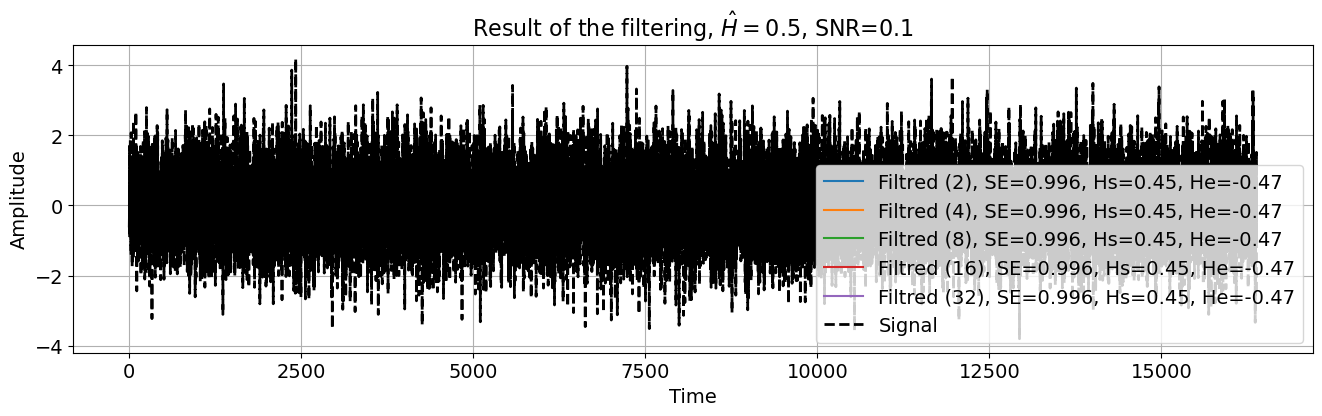

H=0.5, SNR=0.1, SE (order 2): 0.996+-0.004
H=0.5, SNR=0.1, SE (order 4): 0.996+-0.004
H=0.5, SNR=0.1, SE (order 8): 0.996+-0.004
H=0.5, SNR=0.1, SE (order 16): 0.996+-0.004
H=0.5, SNR=0.1, SE (order 32): 0.996+-0.004


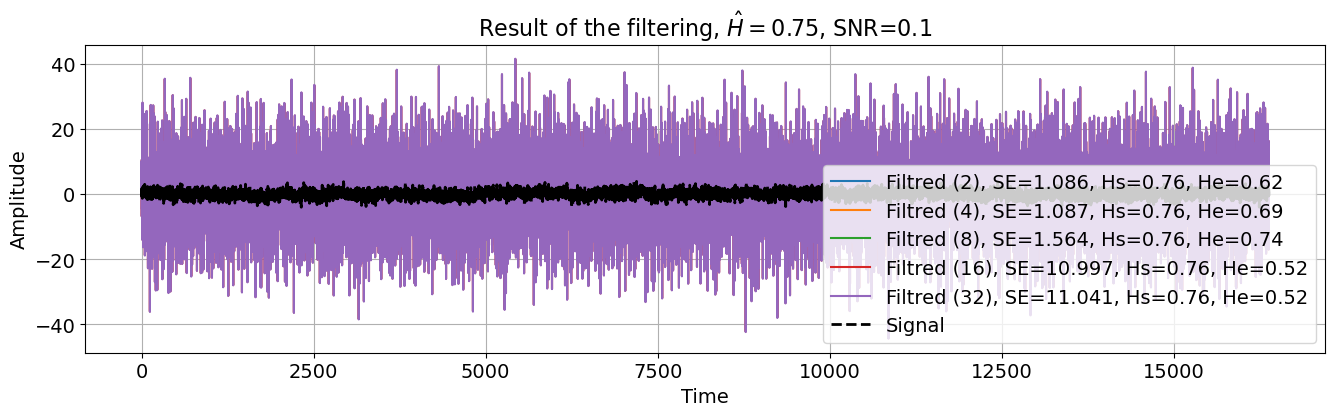

H=0.75, SNR=0.1, SE (order 2): 1.076+-0.009
H=0.75, SNR=0.1, SE (order 4): 1.078+-0.009
H=0.75, SNR=0.1, SE (order 8): 1.561+-0.012
H=0.75, SNR=0.1, SE (order 16): 10.776+-0.130
H=0.75, SNR=0.1, SE (order 32): 10.818+-0.131


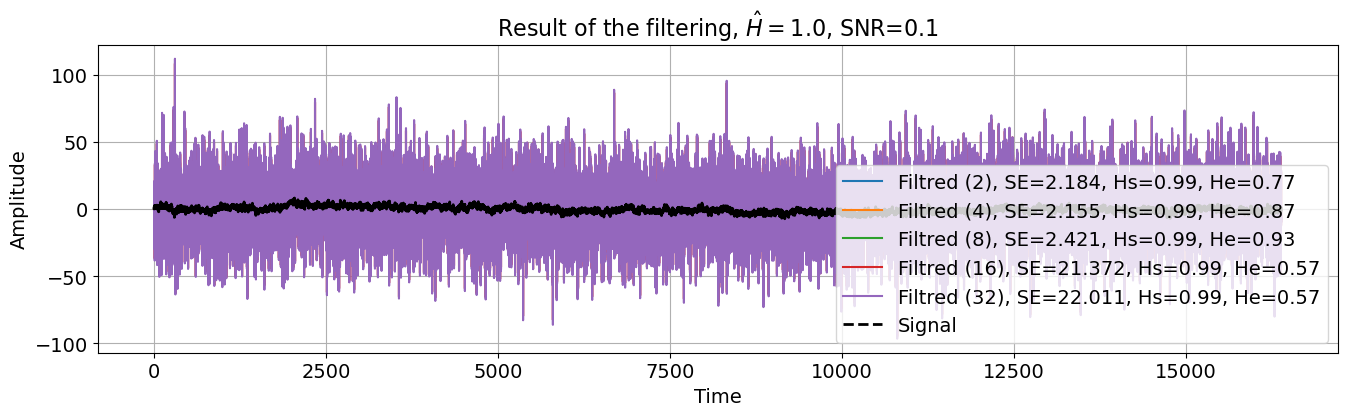

H=1.0, SNR=0.1, SE (order 2): 1.769+-0.149
H=1.0, SNR=0.1, SE (order 4): 1.750+-0.146
H=1.0, SNR=0.1, SE (order 8): 2.343+-0.034
H=1.0, SNR=0.1, SE (order 16): 17.558+-1.398
H=1.0, SNR=0.1, SE (order 32): 17.917+-1.492


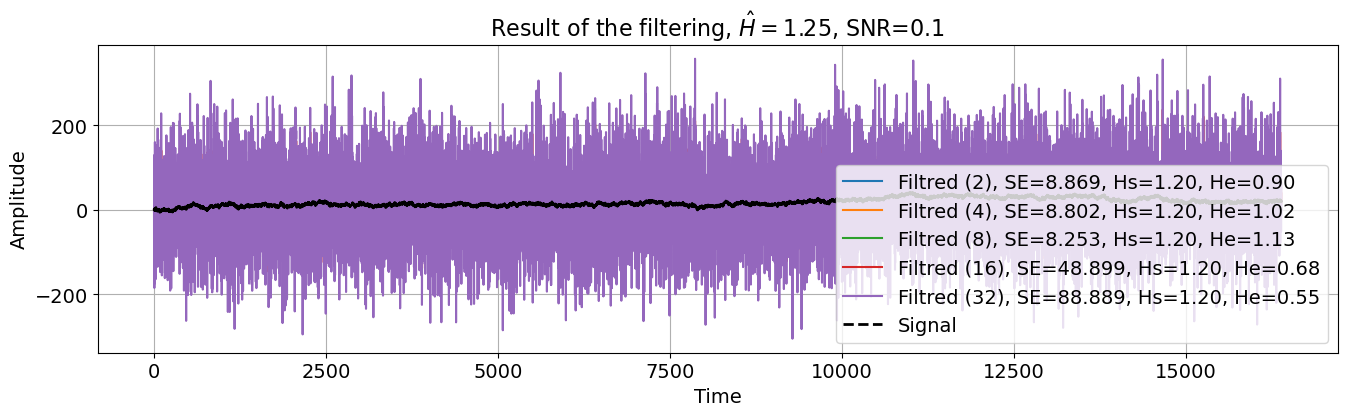

H=1.25, SNR=0.1, SE (order 2): 8.828+-2.519
H=1.25, SNR=0.1, SE (order 4): 8.751+-2.536
H=1.25, SNR=0.1, SE (order 8): 8.177+-2.591
H=1.25, SNR=0.1, SE (order 16): 47.804+-7.185
H=1.25, SNR=0.1, SE (order 32): 88.417+-25.018


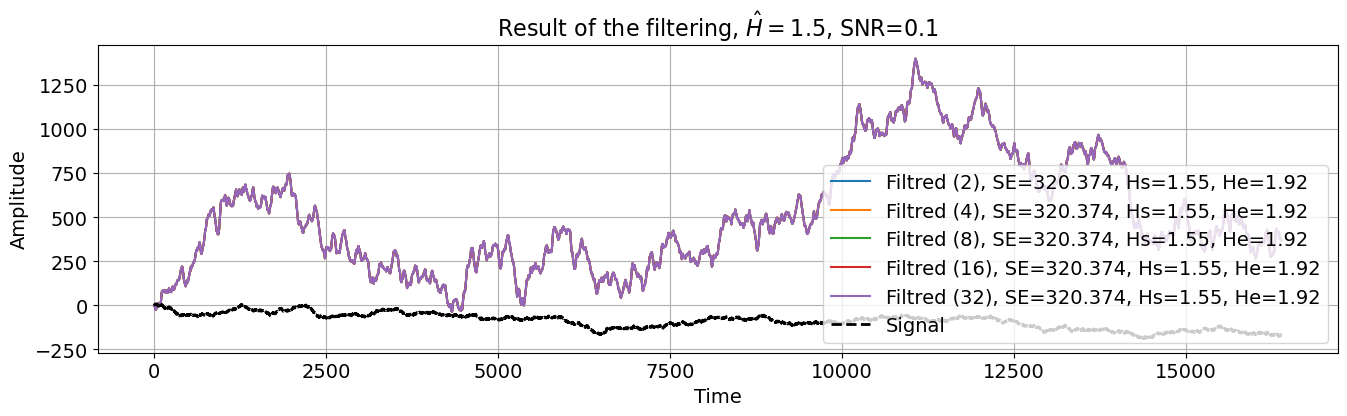

H=1.5, SNR=0.1, SE (order 2): 129.181+-185.952
H=1.5, SNR=0.1, SE (order 4): 129.181+-185.952
H=1.5, SNR=0.1, SE (order 8): 129.181+-185.952
H=1.5, SNR=0.1, SE (order 16): 129.181+-185.952
H=1.5, SNR=0.1, SE (order 32): 129.181+-185.952


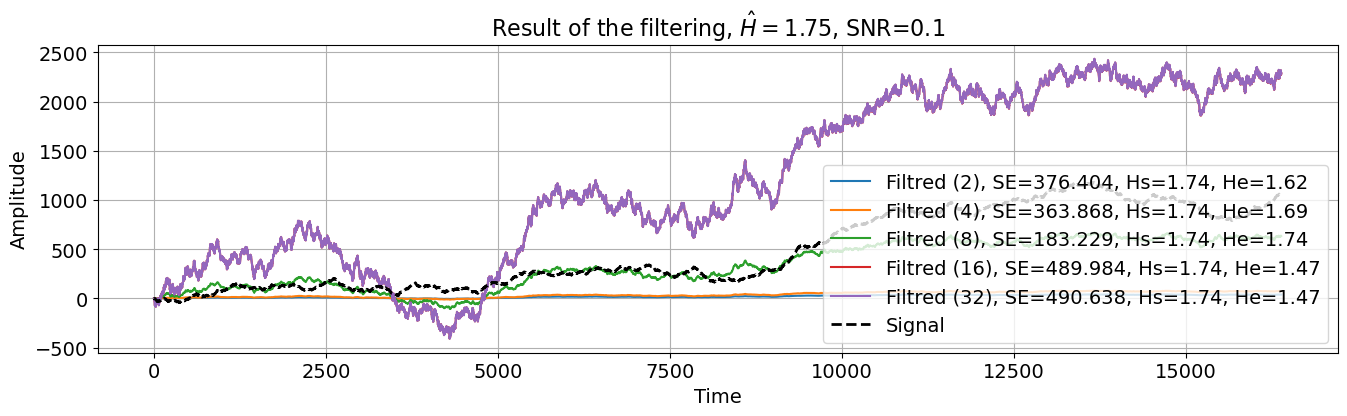

H=1.75, SNR=0.1, SE (order 2): 367.479+-144.724
H=1.75, SNR=0.1, SE (order 4): 359.617+-144.295
H=1.75, SNR=0.1, SE (order 8): 276.544+-131.763
H=1.75, SNR=0.1, SE (order 16): 517.342+-202.921
H=1.75, SNR=0.1, SE (order 32): 517.797+-203.130


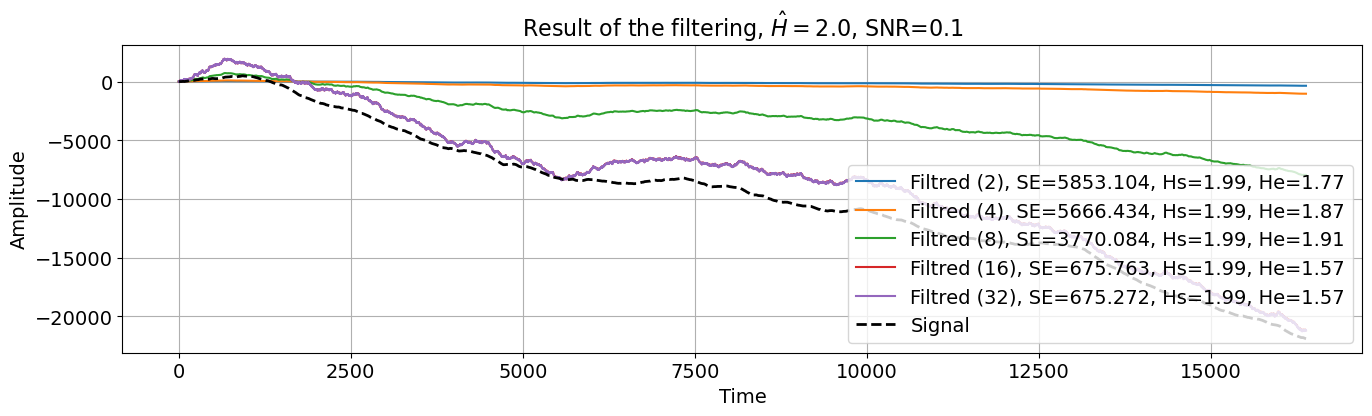

H=2.0, SNR=0.1, SE (order 2): 4505.712+-2367.118
H=2.0, SNR=0.1, SE (order 4): 4365.554+-2310.241
H=2.0, SNR=0.1, SE (order 8): 2912.814+-1675.514
H=2.0, SNR=0.1, SE (order 16): 863.247+-391.371
H=2.0, SNR=0.1, SE (order 32): 865.960+-391.340


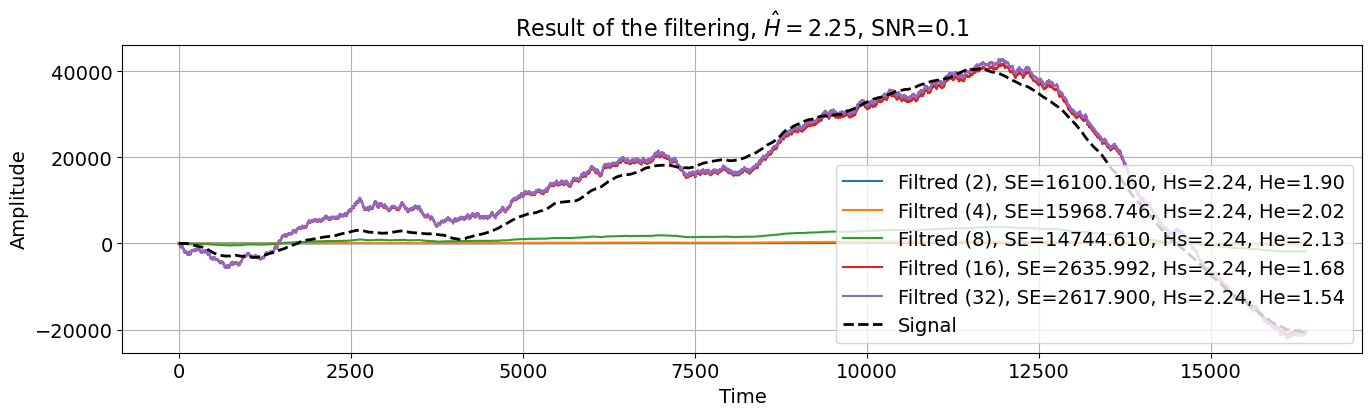

H=2.25, SNR=0.1, SE (order 2): 37953.735+-19626.378
H=2.25, SNR=0.1, SE (order 4): 37384.619+-19384.896
H=2.25, SNR=0.1, SE (order 8): 32606.099+-17246.488
H=2.25, SNR=0.1, SE (order 16): 3185.265+-814.698
H=2.25, SNR=0.1, SE (order 32): 3064.241+-749.036


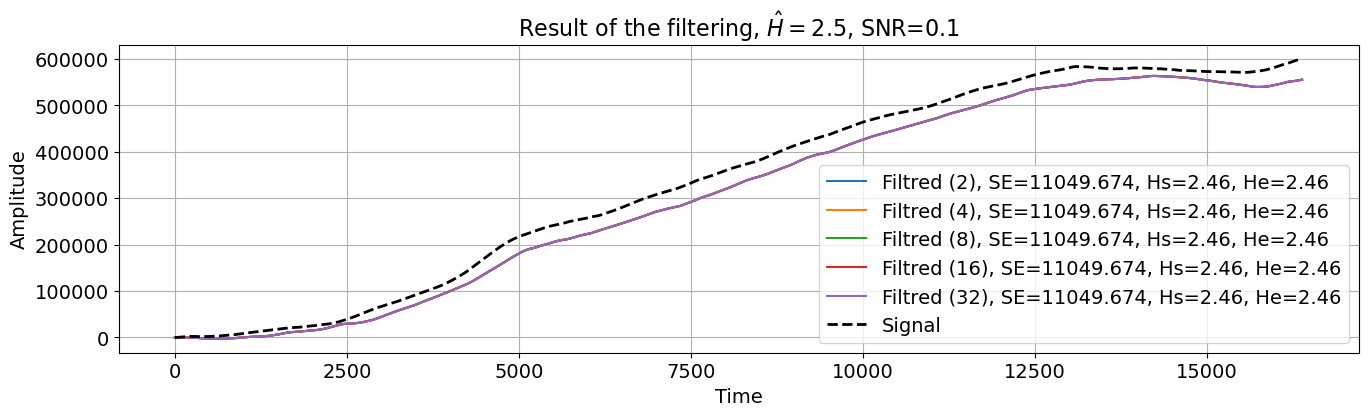

H=2.5, SNR=0.1, SE (order 2): 286491.769+-903922.245
H=2.5, SNR=0.1, SE (order 4): 286491.769+-903922.245
H=2.5, SNR=0.1, SE (order 8): 286491.769+-903922.245
H=2.5, SNR=0.1, SE (order 16): 286491.769+-903922.245
H=2.5, SNR=0.1, SE (order 32): 286491.769+-903922.245


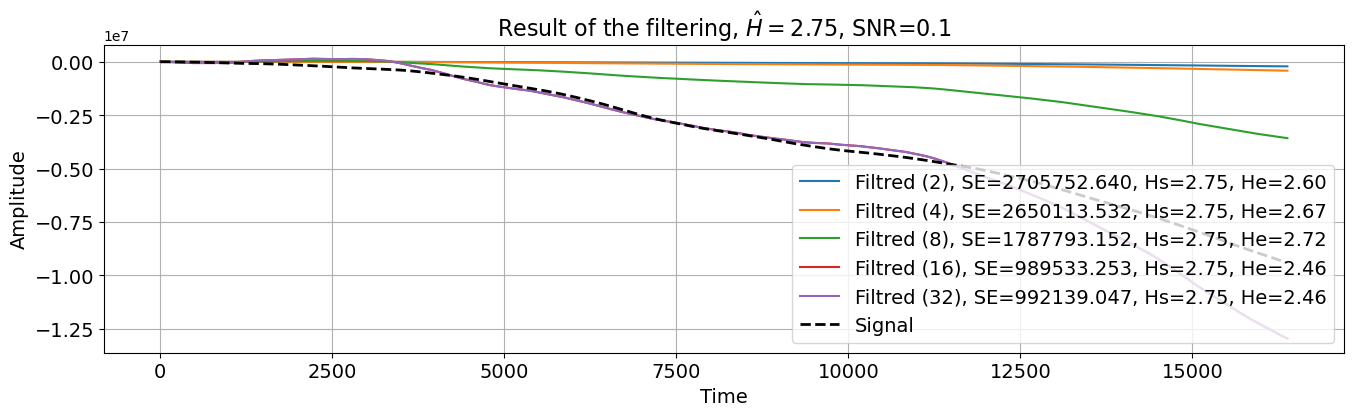

H=2.75, SNR=0.1, SE (order 2): 3323926.894+-1899877.693
H=2.75, SNR=0.1, SE (order 4): 3259376.030+-1860568.599
H=2.75, SNR=0.1, SE (order 8): 2618801.658+-1126429.506
H=2.75, SNR=0.1, SE (order 16): 3946897.931+-2700243.132
H=2.75, SNR=0.1, SE (order 32): 3950436.268+-2703048.808


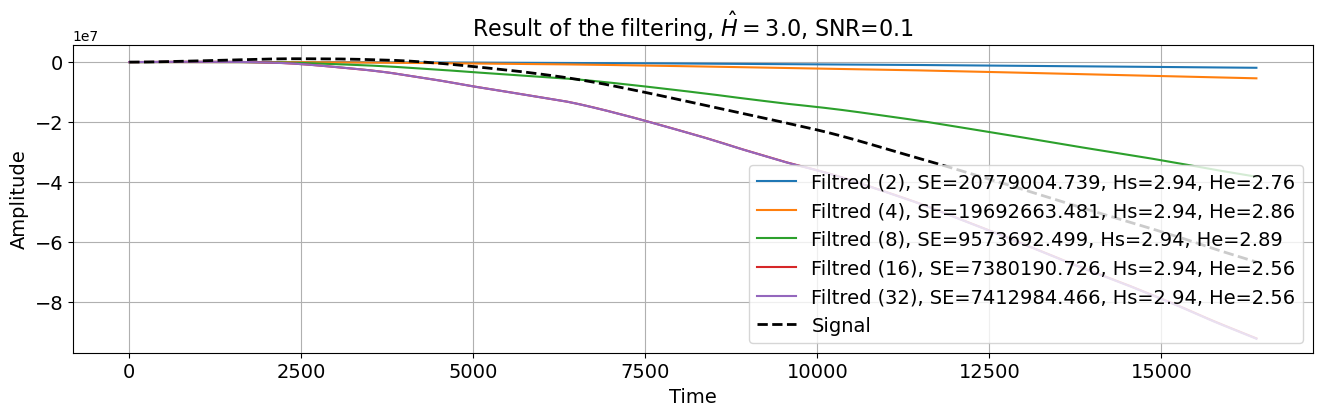

H=3.0, SNR=0.1, SE (order 2): 28811371.790+-13878821.019
H=3.0, SNR=0.1, SE (order 4): 28051776.895+-13593855.581
H=3.0, SNR=0.1, SE (order 8): 20086823.022+-10512792.435
H=3.0, SNR=0.1, SE (order 16): 7787209.236+-4092753.704
H=3.0, SNR=0.1, SE (order 32): 7774787.047+-4094074.370


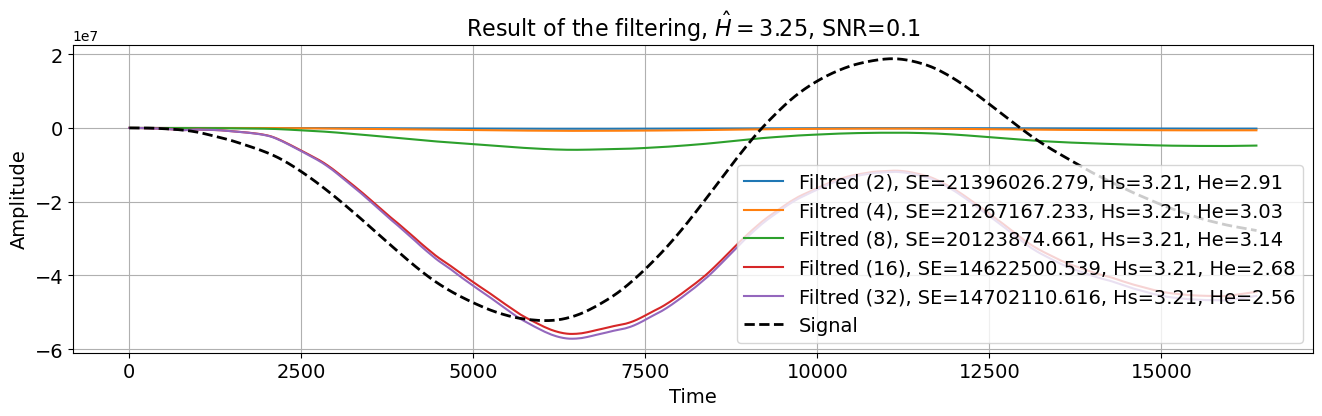

H=3.25, SNR=0.1, SE (order 2): 257773098.683+-175017017.477
H=3.25, SNR=0.1, SE (order 4): 254448489.644+-173830722.106
H=3.25, SNR=0.1, SE (order 8): 226167672.692+-162074360.152
H=3.25, SNR=0.1, SE (order 16): 18618479.404+-11460394.087
H=3.25, SNR=0.1, SE (order 32): 22313389.142+-12495903.320


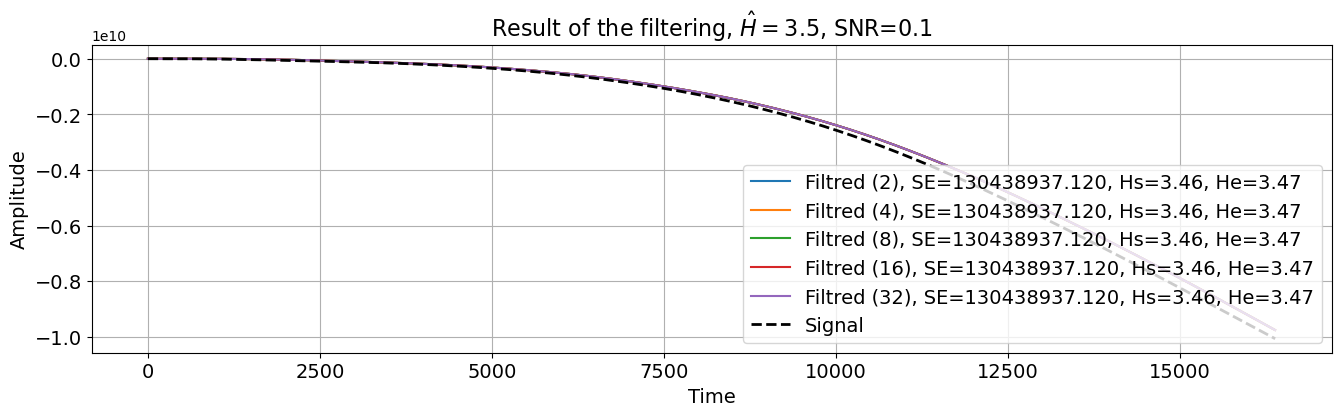

H=3.5, SNR=0.1, SE (order 2): 2255567615.663+-3538857753.208
H=3.5, SNR=0.1, SE (order 4): 2255567615.663+-3538857753.208
H=3.5, SNR=0.1, SE (order 8): 2255567615.663+-3538857753.208
H=3.5, SNR=0.1, SE (order 16): 2255567615.663+-3538857753.208
H=3.5, SNR=0.1, SE (order 32): 2255567615.663+-3538857753.208


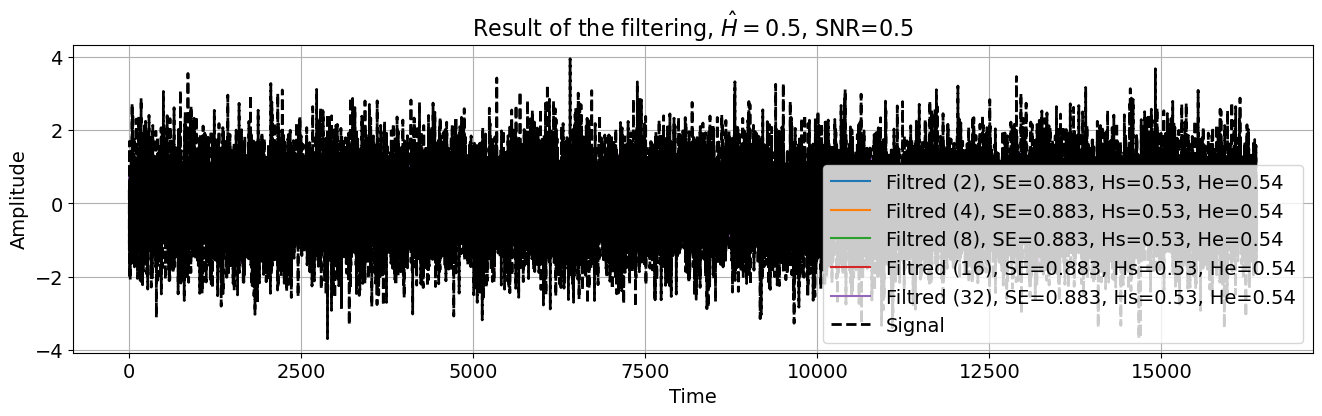

H=0.5, SNR=0.5, SE (order 2): 0.916+-0.044
H=0.5, SNR=0.5, SE (order 4): 0.916+-0.044
H=0.5, SNR=0.5, SE (order 8): 0.916+-0.044
H=0.5, SNR=0.5, SE (order 16): 0.916+-0.044
H=0.5, SNR=0.5, SE (order 32): 0.916+-0.044


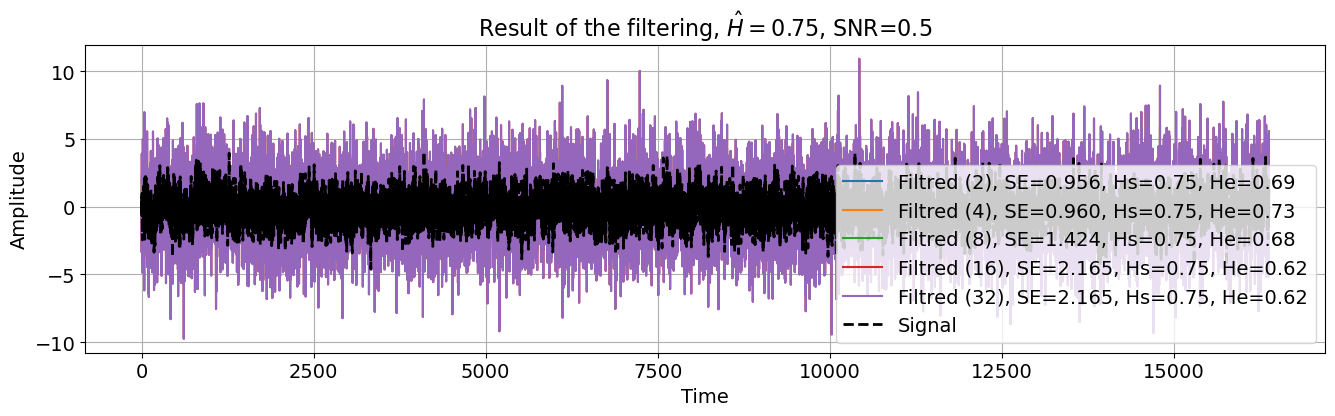

H=0.75, SNR=0.5, SE (order 2): 0.954+-0.008
H=0.75, SNR=0.5, SE (order 4): 0.961+-0.007
H=0.75, SNR=0.5, SE (order 8): 1.424+-0.008
H=0.75, SNR=0.5, SE (order 16): 2.164+-0.019
H=0.75, SNR=0.5, SE (order 32): 2.164+-0.019


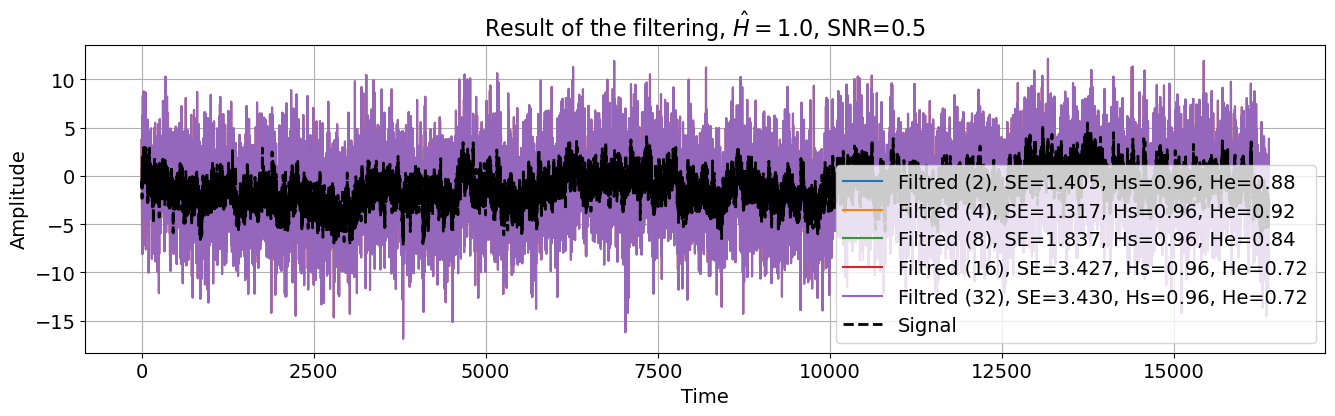

H=1.0, SNR=0.5, SE (order 2): 1.463+-0.089
H=1.0, SNR=0.5, SE (order 4): 1.353+-0.058
H=1.0, SNR=0.5, SE (order 8): 1.863+-0.042
H=1.0, SNR=0.5, SE (order 16): 3.566+-0.206
H=1.0, SNR=0.5, SE (order 32): 3.569+-0.206


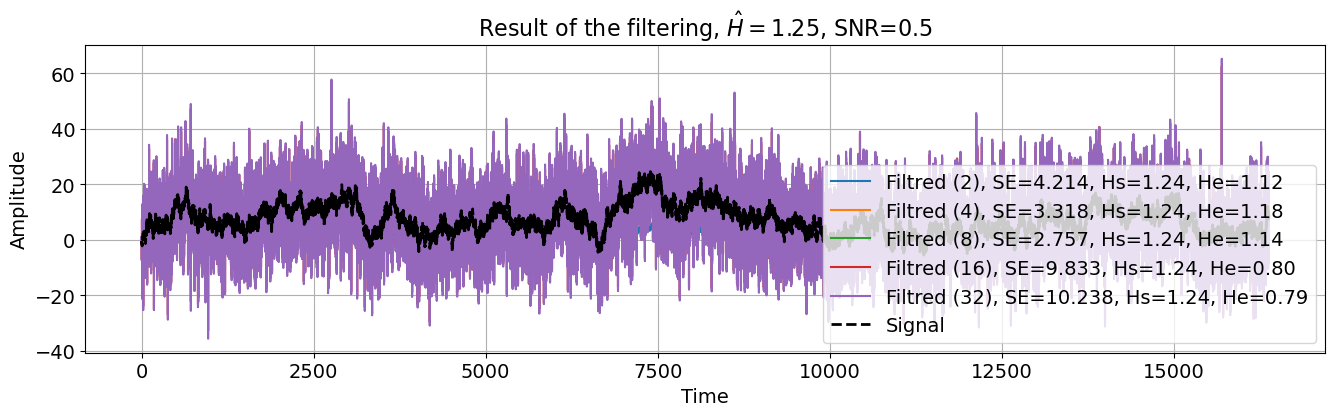

H=1.25, SNR=0.5, SE (order 2): 6.444+-1.843
H=1.25, SNR=0.5, SE (order 4): 5.401+-1.741
H=1.25, SNR=0.5, SE (order 8): 3.662+-0.811
H=1.25, SNR=0.5, SE (order 16): 13.244+-2.848
H=1.25, SNR=0.5, SE (order 32): 14.363+-3.491


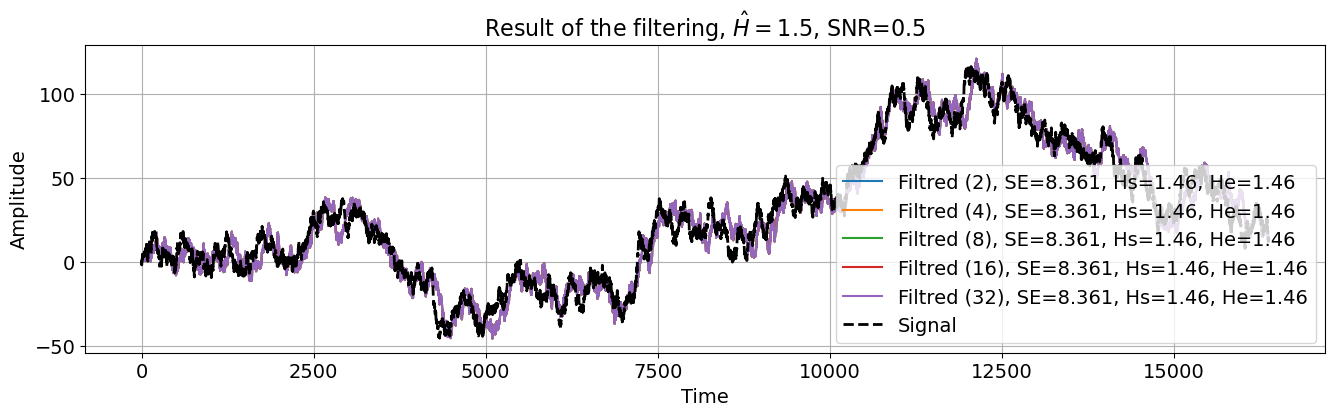

H=1.5, SNR=0.5, SE (order 2): 14.774+-19.424
H=1.5, SNR=0.5, SE (order 4): 14.774+-19.424
H=1.5, SNR=0.5, SE (order 8): 14.774+-19.424
H=1.5, SNR=0.5, SE (order 16): 14.774+-19.424
H=1.5, SNR=0.5, SE (order 32): 14.774+-19.424


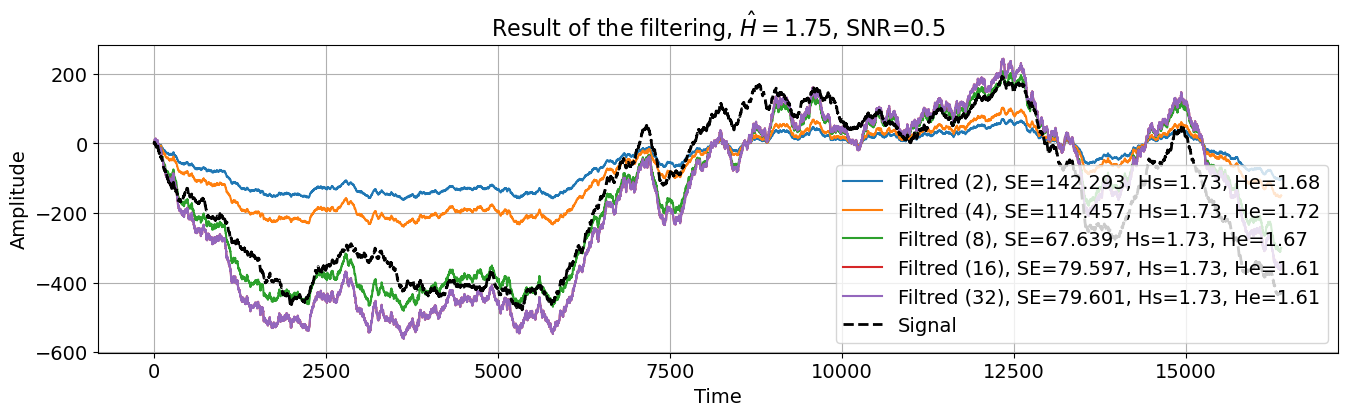

H=1.75, SNR=0.5, SE (order 2): 324.443+-201.277
H=1.75, SNR=0.5, SE (order 4): 270.158+-164.190
H=1.75, SNR=0.5, SE (order 8): 121.334+-57.921
H=1.75, SNR=0.5, SE (order 16): 102.870+-34.997
H=1.75, SNR=0.5, SE (order 32): 102.870+-34.995


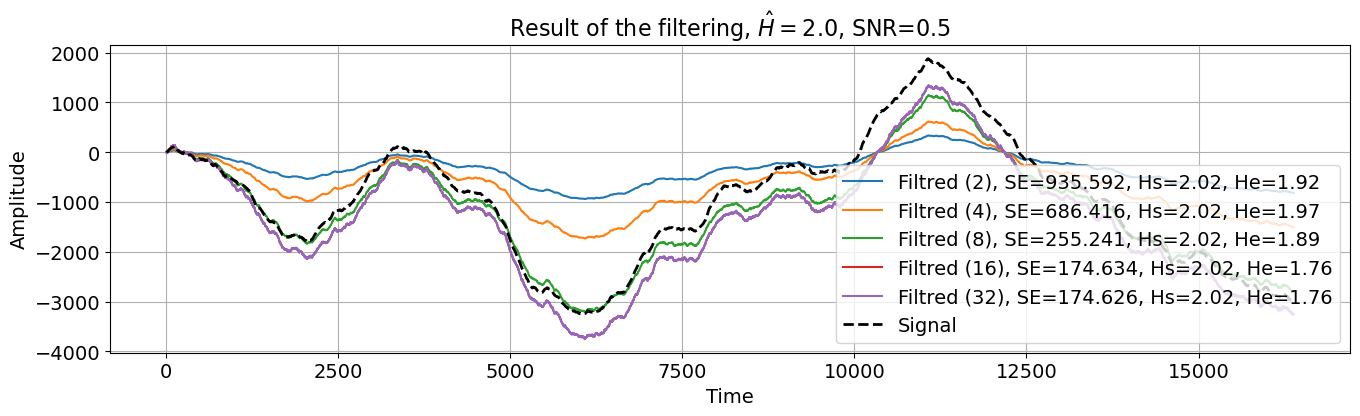

H=2.0, SNR=0.5, SE (order 2): 2850.841+-1568.182
H=2.0, SNR=0.5, SE (order 4): 2004.927+-1097.043
H=2.0, SNR=0.5, SE (order 8): 530.665+-285.735
H=2.0, SNR=0.5, SE (order 16): 176.861+-63.197
H=2.0, SNR=0.5, SE (order 32): 176.868+-63.219


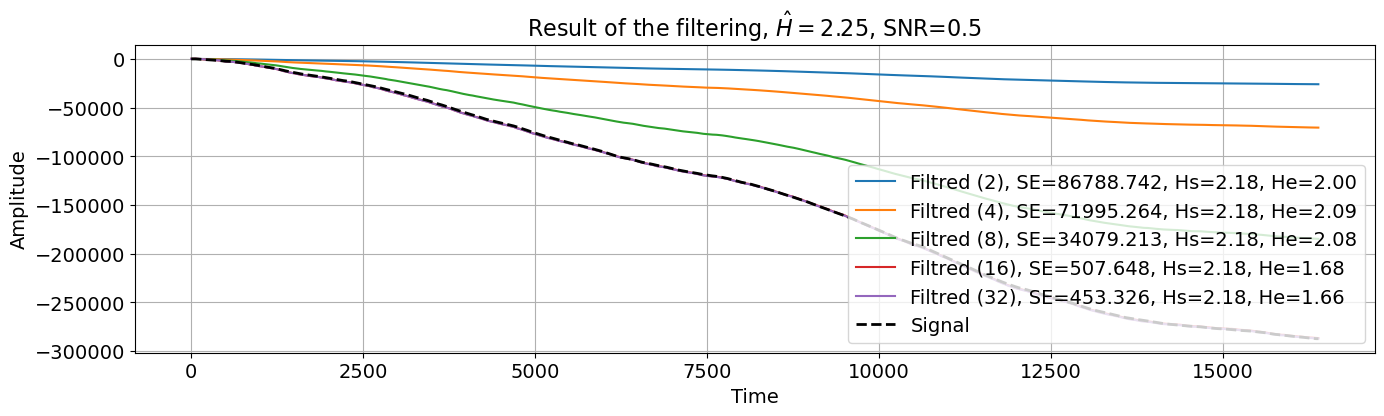

H=2.25, SNR=0.5, SE (order 2): 31061.083+-24059.520
H=2.25, SNR=0.5, SE (order 4): 24760.873+-20004.253
H=2.25, SNR=0.5, SE (order 8): 11176.370+-9450.756
H=2.25, SNR=0.5, SE (order 16): 561.217+-232.855
H=2.25, SNR=0.5, SE (order 32): 550.197+-239.689


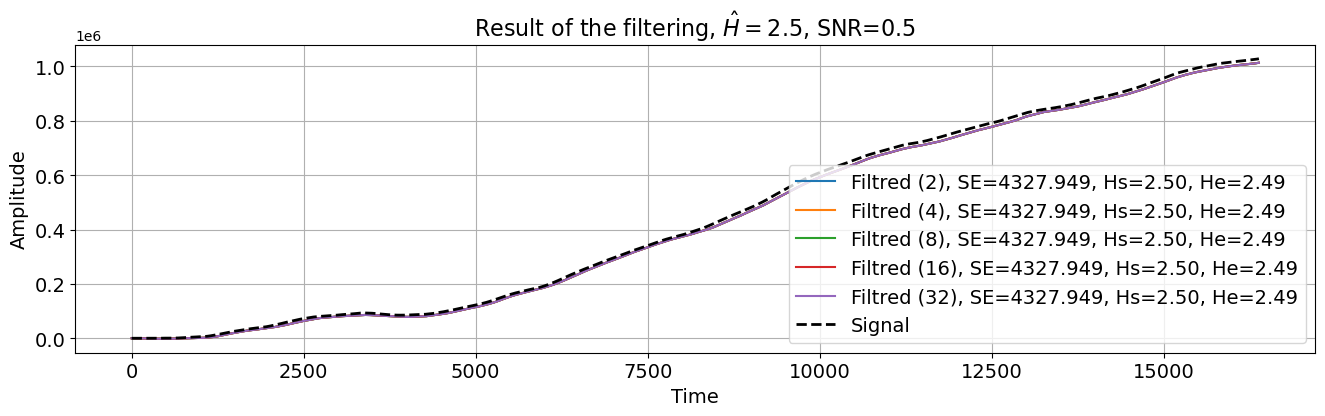

H=2.5, SNR=0.5, SE (order 2): 165259.685+-332473.478
H=2.5, SNR=0.5, SE (order 4): 165259.685+-332473.478
H=2.5, SNR=0.5, SE (order 8): 165259.685+-332473.478
H=2.5, SNR=0.5, SE (order 16): 165259.685+-332473.478
H=2.5, SNR=0.5, SE (order 32): 165259.685+-332473.478


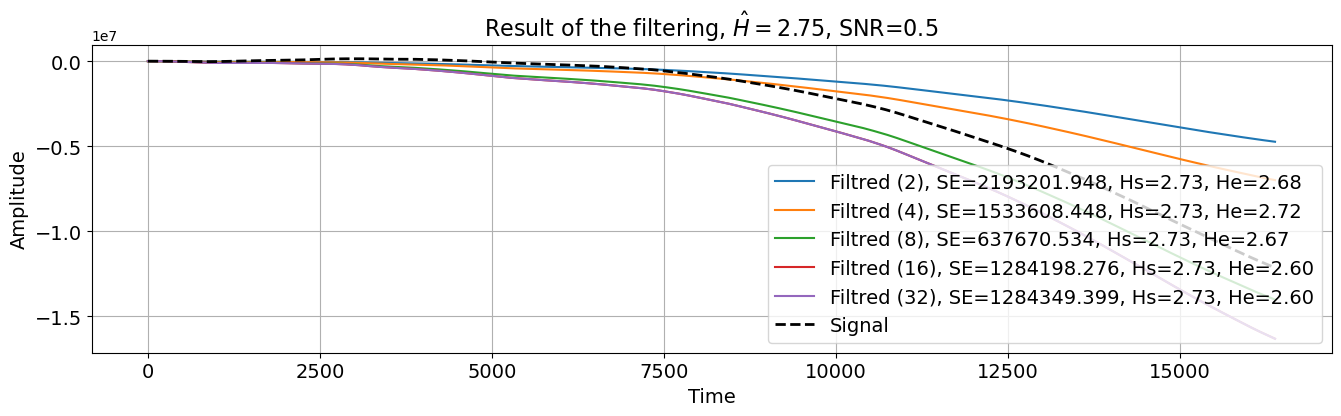

H=2.75, SNR=0.5, SE (order 2): 1956051.958+-1282542.953
H=2.75, SNR=0.5, SE (order 4): 1583133.148+-1041129.150
H=2.75, SNR=0.5, SE (order 8): 719061.997+-410359.579
H=2.75, SNR=0.5, SE (order 16): 741987.929+-406255.846
H=2.75, SNR=0.5, SE (order 32): 742006.625+-406298.504


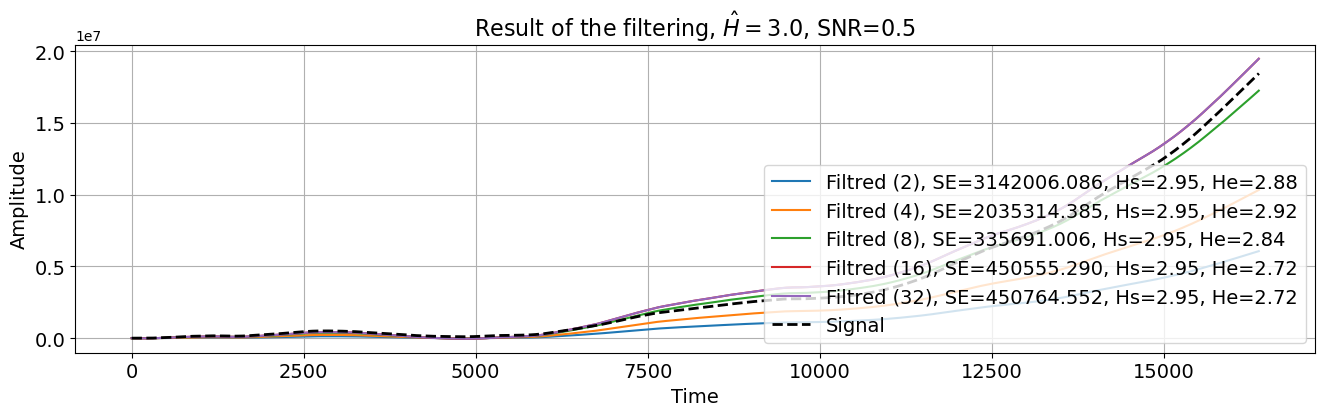

H=3.0, SNR=0.5, SE (order 2): 12633523.466+-11314244.690
H=3.0, SNR=0.5, SE (order 4): 8697354.092+-7840659.651
H=3.0, SNR=0.5, SE (order 8): 2302730.605+-1775104.845
H=3.0, SNR=0.5, SE (order 16): 1281175.233+-729300.739
H=3.0, SNR=0.5, SE (order 32): 1281722.571+-729330.379


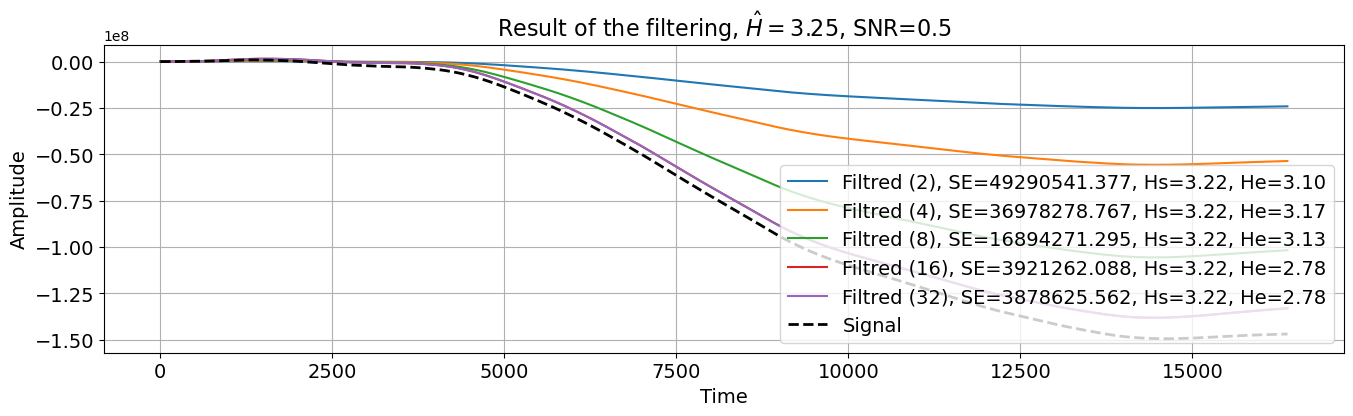

H=3.25, SNR=0.5, SE (order 2): 166994008.957+-150872128.319
H=3.25, SNR=0.5, SE (order 4): 137589174.865+-129878735.443
H=3.25, SNR=0.5, SE (order 8): 66050535.583+-69950864.285
H=3.25, SNR=0.5, SE (order 16): 5758269.682+-5125034.195
H=3.25, SNR=0.5, SE (order 32): 5777514.049+-4807995.936


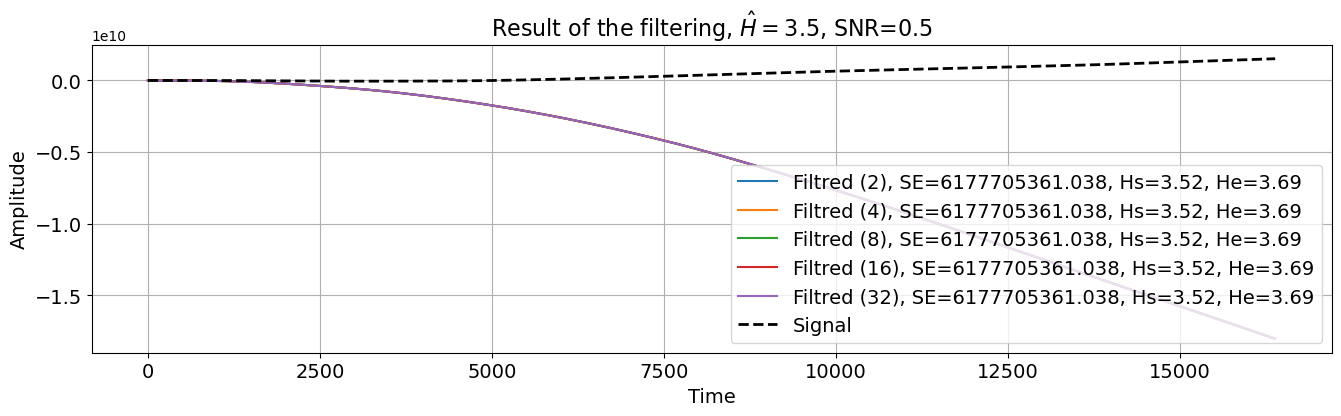

H=3.5, SNR=0.5, SE (order 2): 676714002.383+-1591606024.015
H=3.5, SNR=0.5, SE (order 4): 676714002.383+-1591606024.015
H=3.5, SNR=0.5, SE (order 8): 676714002.383+-1591606024.015
H=3.5, SNR=0.5, SE (order 16): 676714002.383+-1591606024.015
H=3.5, SNR=0.5, SE (order 32): 676714002.383+-1591606024.015


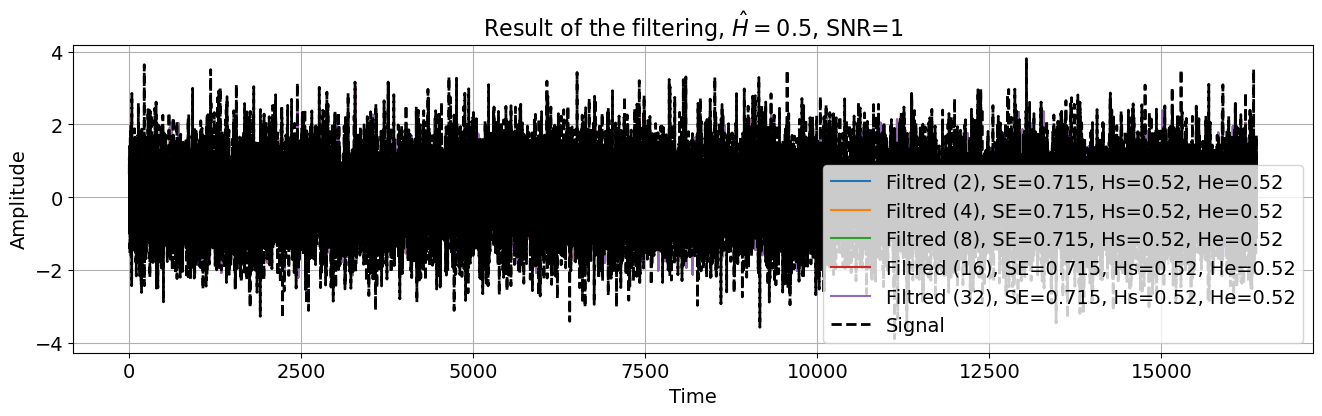

H=0.5, SNR=1, SE (order 2): 0.746+-0.101
H=0.5, SNR=1, SE (order 4): 0.746+-0.101
H=0.5, SNR=1, SE (order 8): 0.746+-0.101
H=0.5, SNR=1, SE (order 16): 0.746+-0.101
H=0.5, SNR=1, SE (order 32): 0.746+-0.101


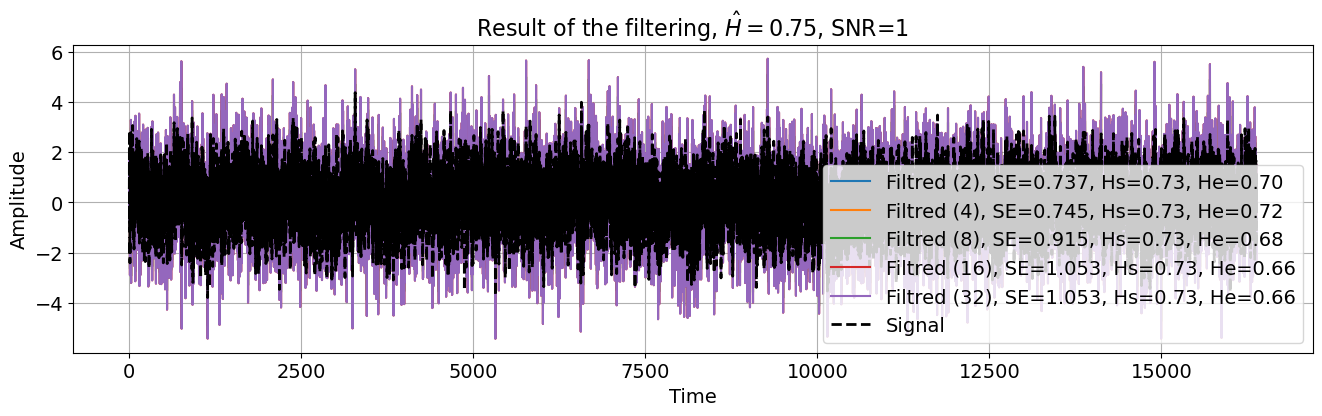

H=0.75, SNR=1, SE (order 2): 0.751+-0.009
H=0.75, SNR=1, SE (order 4): 0.757+-0.008
H=0.75, SNR=1, SE (order 8): 0.935+-0.010
H=0.75, SNR=1, SE (order 16): 1.084+-0.015
H=0.75, SNR=1, SE (order 32): 1.084+-0.015


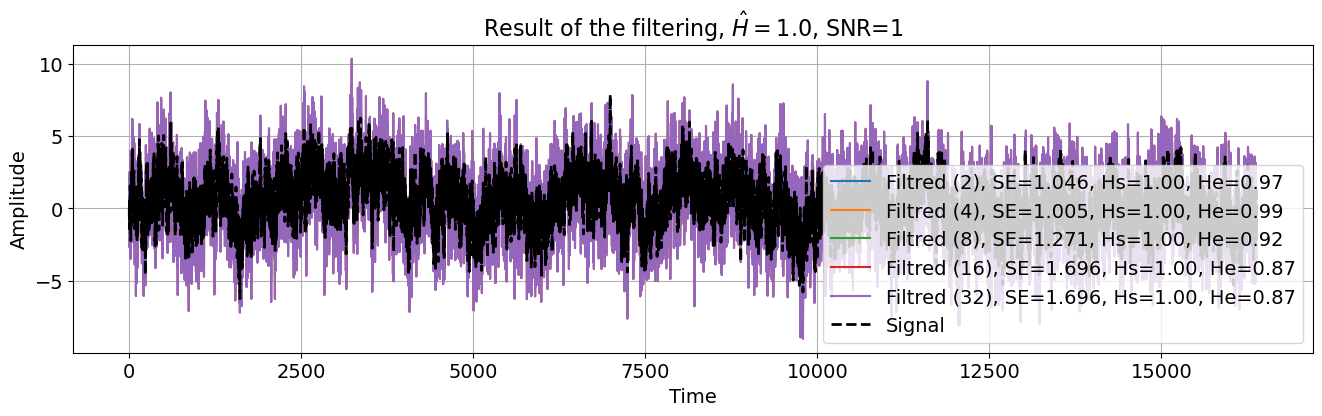

H=1.0, SNR=1, SE (order 2): 1.102+-0.066
H=1.0, SNR=1, SE (order 4): 1.040+-0.041
H=1.0, SNR=1, SE (order 8): 1.314+-0.051
H=1.0, SNR=1, SE (order 16): 1.790+-0.112
H=1.0, SNR=1, SE (order 32): 1.791+-0.112


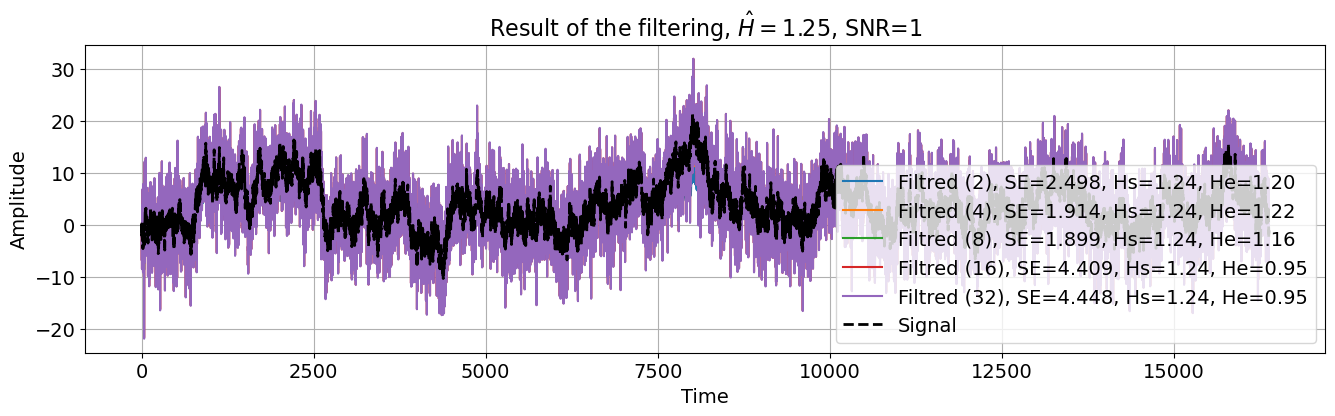

H=1.25, SNR=1, SE (order 2): 5.721+-2.415
H=1.25, SNR=1, SE (order 4): 4.176+-1.897
H=1.25, SNR=1, SE (order 8): 2.744+-0.668
H=1.25, SNR=1, SE (order 16): 7.509+-2.142
H=1.25, SNR=1, SE (order 32): 7.741+-2.335


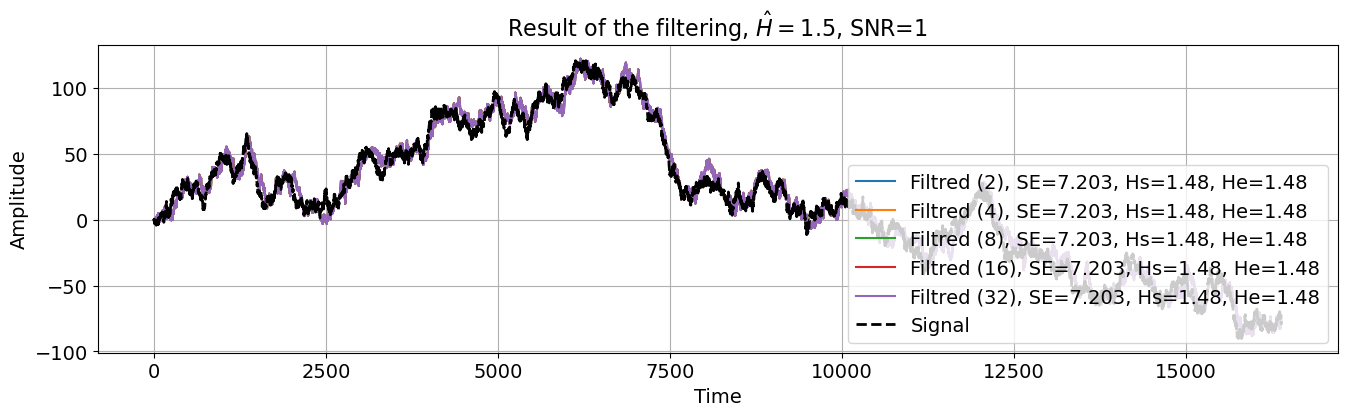

H=1.5, SNR=1, SE (order 2): 8.753+-7.334
H=1.5, SNR=1, SE (order 4): 8.753+-7.334
H=1.5, SNR=1, SE (order 8): 8.753+-7.334
H=1.5, SNR=1, SE (order 16): 8.753+-7.334
H=1.5, SNR=1, SE (order 32): 8.753+-7.334


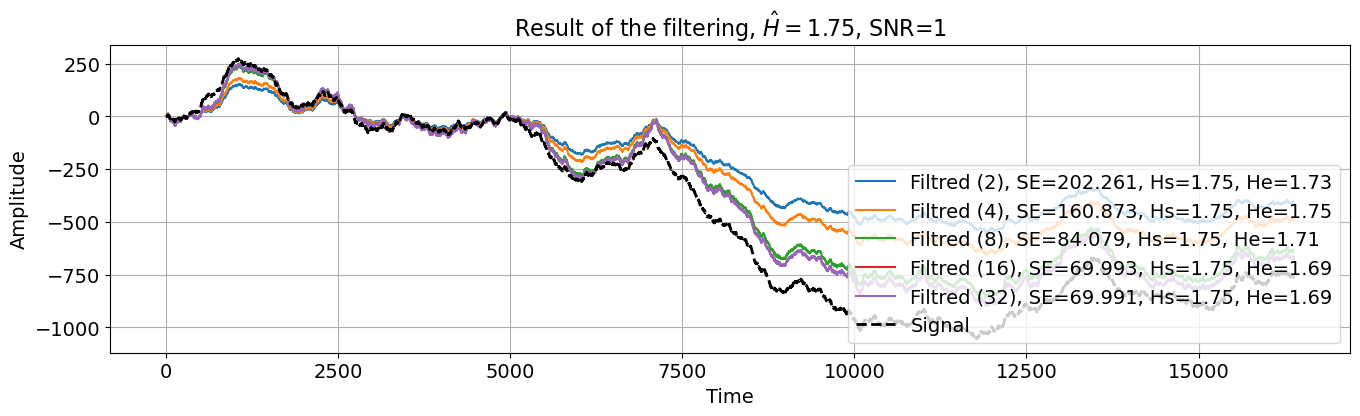

H=1.75, SNR=1, SE (order 2): 158.025+-71.634
H=1.75, SNR=1, SE (order 4): 113.421+-54.965
H=1.75, SNR=1, SE (order 8): 57.046+-29.952
H=1.75, SNR=1, SE (order 16): 60.013+-25.645
H=1.75, SNR=1, SE (order 32): 60.014+-25.645


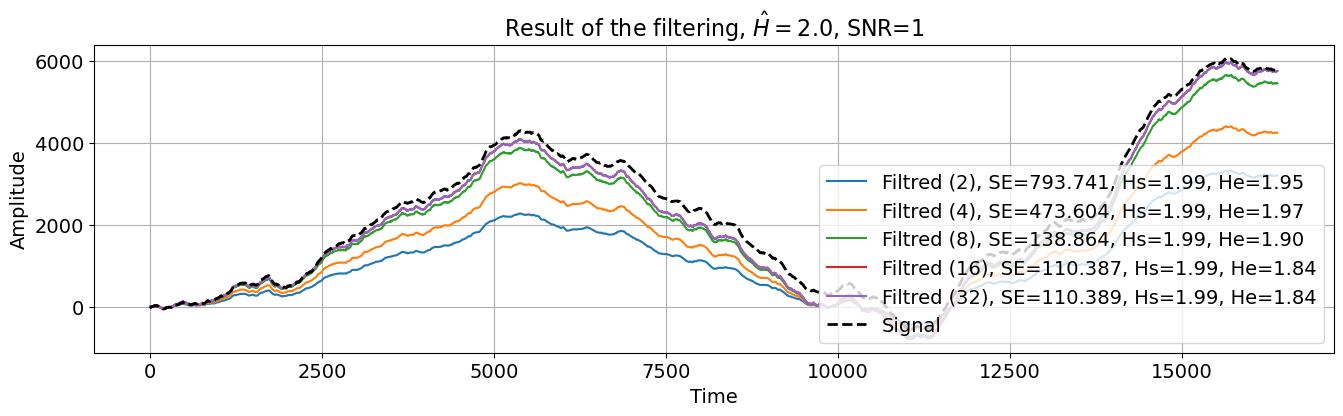

H=2.0, SNR=1, SE (order 2): 1567.974+-1070.980
H=2.0, SNR=1, SE (order 4): 940.036+-643.437
H=2.0, SNR=1, SE (order 8): 231.887+-148.530
H=2.0, SNR=1, SE (order 16): 105.137+-48.910
H=2.0, SNR=1, SE (order 32): 105.117+-48.905


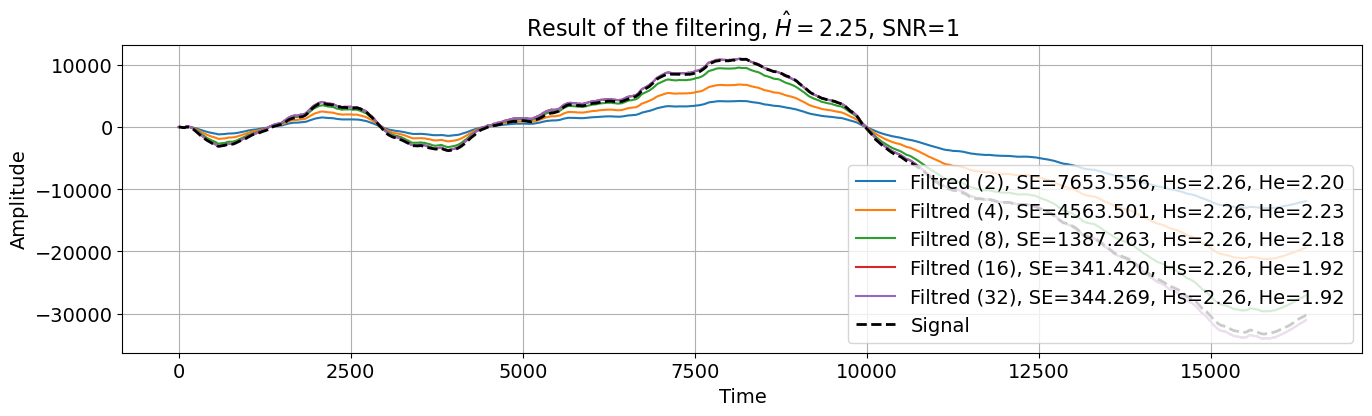

H=2.25, SNR=1, SE (order 2): 22923.548+-15262.192
H=2.25, SNR=1, SE (order 4): 15139.883+-10546.462
H=2.25, SNR=1, SE (order 8): 5572.866+-4138.285
H=2.25, SNR=1, SE (order 16): 284.455+-97.198
H=2.25, SNR=1, SE (order 32): 285.323+-97.599


In [ ]:
# one process version with plot
s = TRJ_LEN
axis_fontsize = 14
label_fontsize = 14
legend_fontsize = 14
title_fontsize = 16
SNR_LIST = [0.1, 0.5, 1, 2]
n = 15
for snr in SNR_LIST:
    for h in H_LIST:
        se_dict = {}
        for r in get_r_list():
            se_dict[r] = []
    
        for i in range(n):
            signal = get_signal(h, TRJ_LEN, s, normalize=False)
            if i == 0:
                plt.figure(figsize=(16, 4))
            adjusted_signal, applied_steps = adjust_hurst_to_range(signal)
            noisy_signal, noise = add_noise(adjusted_signal, ratio=snr)
            r_list = get_r_list()
            h_s = get_extra_h_dfa(signal)
            for r in r_list:
                estimated_signal = apply_kalman_filter_cached(noisy_signal, model_h=h, r=r, noise=noise, cache_folder=kalman_cache_folder)
                estimated_signal = reverse_hurst_adjustment(estimated_signal, applied_steps)
                se = np.nanstd(signal[0 : len(estimated_signal)] - estimated_signal)
                se_dict[r].append(se)
    
                h_est = get_extra_h_dfa(estimated_signal)
                if i == 0:
                    plt.plot(
                        estimated_signal,
                        label=f"Filtred ({r}), SE={se:.3f}, Hs={h_s:.2f}, He={h_est:.2f}",
                        # alpha=0.5,
                    )
    
                metrics_df.loc[len(metrics_df)] = [
                    h,
                    h_s,
                    h_est,
                    len(signal),
                    s,
                    r,
                    snr,
                    se,
                ]
    
            if i == 0:
                plt.plot(
                    signal,
                    label="Signal",
                    color="black",
                    linestyle="--",
                    # alpha=0.5,
                    linewidth=2,
                )
                plt.xlabel("Time", fontsize=axis_fontsize)
                plt.ylabel("Amplitude", fontsize=axis_fontsize)
                # plt.xlim(2000, 2200)
                plt.legend(fontsize=legend_fontsize, loc="lower right")
                plt.tick_params(labelsize=label_fontsize)
                plt.title(
                    f"Result of the filtering, $\\hat{{H}}=${h}, SNR={snr}",
                    fontdict={"fontsize": title_fontsize},
                )
                plt.grid(True)
                plt.show()
    
        for k, v in se_dict.items():
            print(f"H={h}, SNR={snr}, SE (order {k}): {np.mean(v):.3f}+-{np.std(v):.3f}")

In [ ]:
metrics_df.to_csv(output_path / "kalman-kasdin-noise.csv", index=False)

#### Analysis

In [46]:
metrics_df = pd.read_csv(output_path / "kalman-kasdin-noise.csv")
metrics_df.head()

H_target  H_signal  H_restored  signal_len        s     r  SNR        SE
0       0.5  0.515923    0.456919     16384.0  16384.0   2.0  0.5  0.898742
1       0.5  0.515923    0.456919     16384.0  16384.0   4.0  0.5  0.898742
2       0.5  0.515923    0.456919     16384.0  16384.0   8.0  0.5  0.898742
3       0.5  0.515923    0.456919     16384.0  16384.0  16.0  0.5  0.898742
4       0.5  0.515923    0.456919     16384.0  16384.0  32.0  0.5  0.898742

In [47]:
metrics_df["H_restore_diff"] = abs(metrics_df["H_signal"] - metrics_df["H_restored"])
metrics_df["H_gen_diff"] = abs(metrics_df["H_target"] - metrics_df["H_signal"])

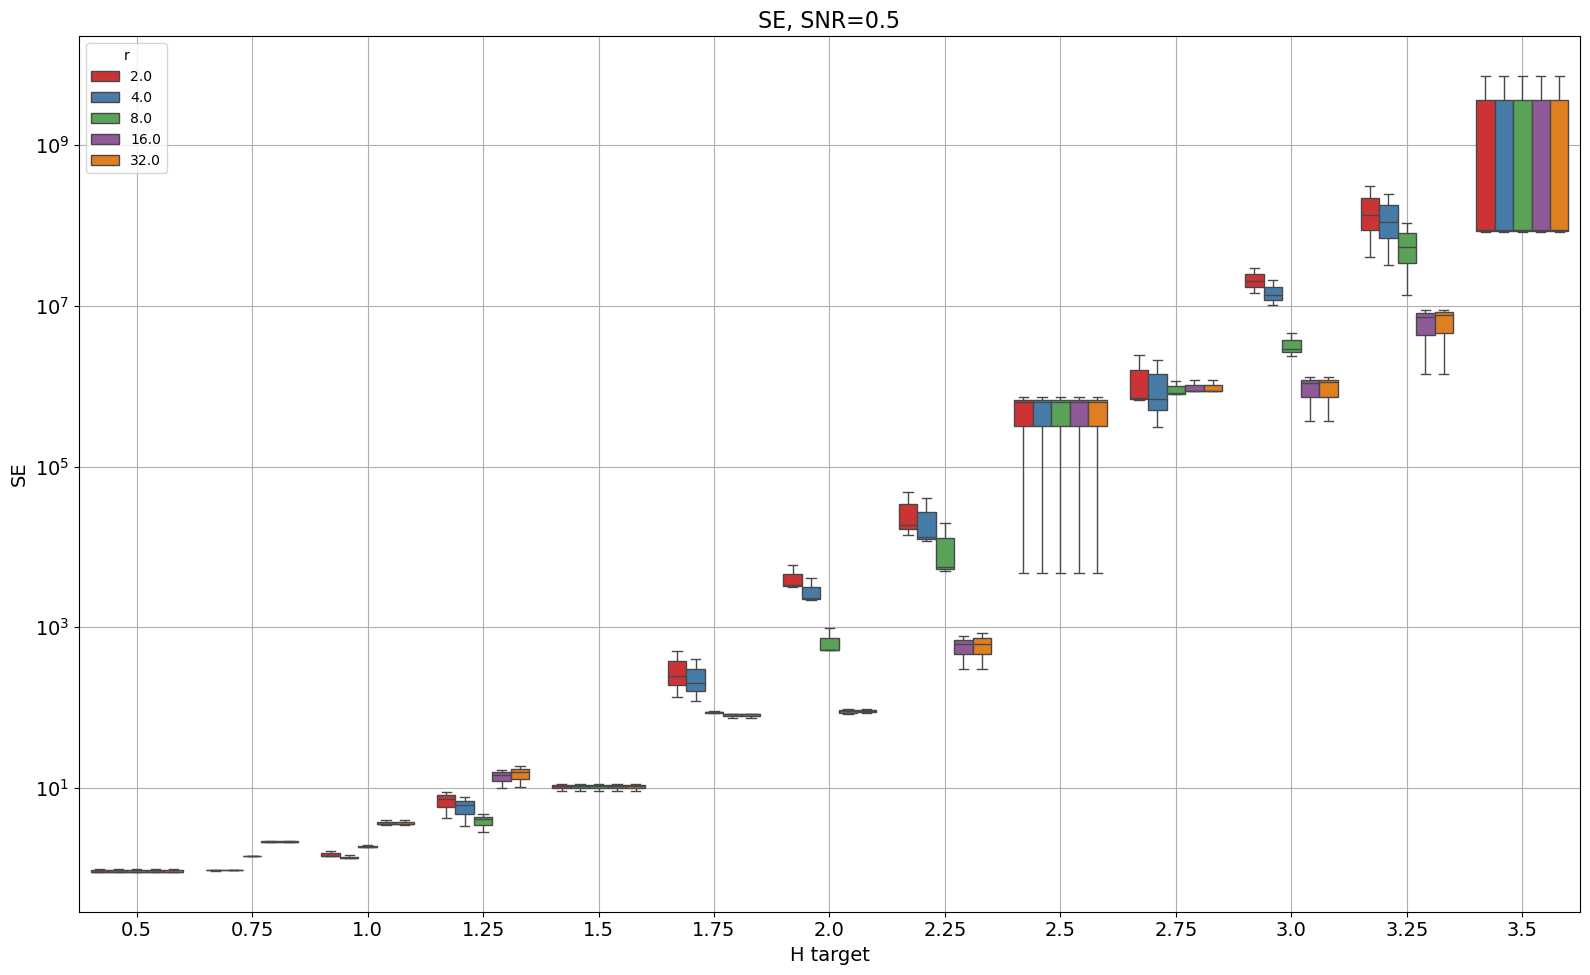

In [56]:
for snr in metrics_df["SNR"].unique():
    plt.figure(figsize=(16, 10))

    part_metrics_df = metrics_df[metrics_df["SNR"] == snr]

    sns.boxplot(x='H_target', y='SE', hue='r',  data=part_metrics_df, palette='tab10') #sns.color_palette("tab10")
    plt.title(f"SE, SNR={snr}", fontdict={"fontsize": 16})
    plt.suptitle("")
    plt.xlabel("H target", fontsize=14)
    plt.ylabel("SE", fontsize=14)
    plt.yscale("log")
    plt.tick_params(labelsize=14)
    plt.tight_layout()
    plt.grid()
    plt.show()

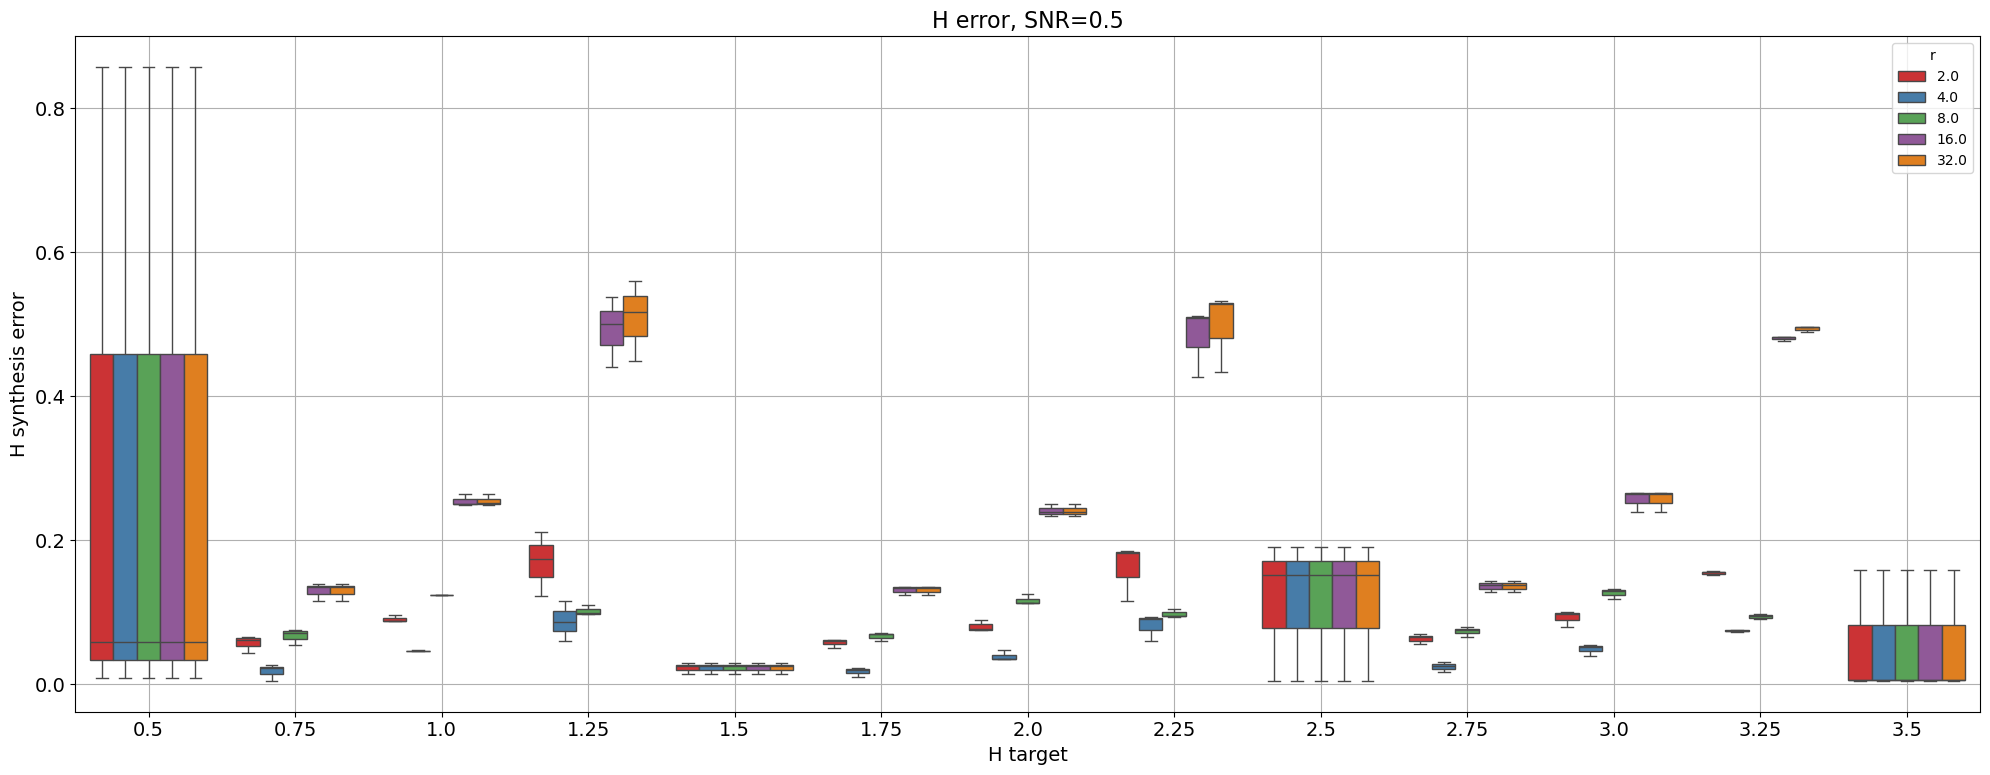

In [55]:
for snr in metrics_df["SNR"].unique():
    plt.figure(figsize=(20, 8))

    part_metrics_df = metrics_df[metrics_df["SNR"] == snr]

    sns.boxplot(x='H_target', y='H_restore_diff', hue='r',  data=part_metrics_df, palette='Set1')
    plt.title(f"H error, SNR={snr}", fontdict={"fontsize": 16})
    plt.suptitle("")
    plt.xlabel("H target", fontsize=14)
    plt.ylabel("H synthesis error", fontsize=14)
    # plt.yscale("log")
    plt.tick_params(labelsize=14)
    plt.tight_layout()
    plt.grid()
    plt.show()

In [ ]:
for r in metrics_df["r"].unique():
    r_metrics_df = metrics_df[metrics_df["r"] == r]
    for snr in metrics_df["SNR"].unique():
        part_metrics_df = r_metrics_df[r_metrics_df["SNR"] == snr]
        ax = part_metrics_df.boxplot(
            column="H_restore_diff", by="H_target", figsize=(6, 4)
        )
        plt.title(f"H error, r={r}, SNR={snr}", fontdict={"fontsize": 16})
        plt.suptitle("")
        plt.xlabel("H target", fontsize=14)
        plt.ylabel("H synthesis error", fontsize=14)
        plt.tick_params(labelsize=14)
        plt.tight_layout()
        plt.show()

In [ ]:
for r in metrics_df["r"].unique():
    r_metrics_df = metrics_df[metrics_df["r"] == r]
    for snr in metrics_df["SNR"].unique():
        part_metrics_df = r_metrics_df[r_metrics_df["SNR"] == snr]
        ax = part_metrics_df.boxplot(
            column="SE", by="H_target", figsize=(6, 4)
        )
        plt.title(f"H error, r={r}, SNR={snr}", fontdict={"fontsize": 16})
        plt.suptitle("")
        plt.xlabel("H target", fontsize=14)
        plt.ylabel("H synthesis error", fontsize=14)
        plt.yscale("log")
        plt.tick_params(labelsize=14)
        plt.tight_layout()
        plt.show()